In [1]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from upsetplot import UpSet
from upsetplot import from_indicators
import polars as pl

# from matplotlib_venn import venn2
from scipy import stats
import duckdb

sns.set_style("whitegrid")

In [2]:
with open("../ptu_derep/derep_plasmids_ids.txt") as f:
    plasmid_count = defaultdict(int)
    plasmid_oids = []
    isolate_oids = []
    derep_plasmids = [i.strip() for i in f]
    derep_plasmids = [i.split("|")[0] if "IMGPR" in i else i for i in derep_plasmids]
    for i in derep_plasmids:
        if i.startswith("IMGPR"):
            plasmid_oids.append(i.strip().split("_")[2])
            isolate_oids.append(i.strip().split("_")[2])
        elif i.startswith("PLSDB") or i.startswith("Refsoil"):
            plasmid_oids.append("_".join(i.strip().split("_")[1:]))
            isolate_oids.append("_".join(i.strip().split("_")[1:]))
        else:
            plasmid_oids.append(i.strip().split("|")[0])

for i in plasmid_oids:
    if i.startswith("IMGPR"):
        plasmid_count[i.split("_")[2]] += 1
    elif i.startswith("PLSDB") or i.startswith("Refsoil"):
        plasmid_count[i] += 1
    else:
        plasmid_count[i.split("|")[0]] += 1

In [3]:
print(
    f" There are {sum(plasmid_count.values())} total plasmids, from {len(set(plasmid_oids))} oids, where {len(set(isolate_oids))} are isolates and {len(set(plasmid_oids)) - len(set(isolate_oids))} are from meta studies"
)

 There are 98281 total plasmids, from 6913 oids, where 3629 are isolates and 3284 are from meta studies


In [4]:
df_for_map = pd.read_csv("../env_corr/taxon_countries.tsv", sep="\t")
df_for_map["taxon_oid"] = df_for_map["taxon_oid"].astype(str)
df_for_map[df_for_map["taxon_oid"].isin(plasmid_oids + isolate_oids)]

df_for_map.head()

,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Isolation Country,Ecosystem Subtype Custom,Plasmid Count,soil_class,bdod (cg/cm³),...,silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM
0,3300049023,Grasslands,38.53,-121.78,Meta,USA,Grasslands,36,Luvisols,152.0,...,562.0,335.0,POINT (-121.78 38.53),761.0,Great Central Valley,NaN,NA12,Nearctic,12.0,"Mediterranean Forests, Woodlands and Scrub"
1,3300012840,Grasslands,43.07,-89.40,Meta,USA,Grasslands,21,Luvisols,NaN,...,NaN,NaN,POINT (-89.4 43.07),187.0,Prairie-Forest Border,NaN,NA4,Nearctic,4.0,Temperate Broadleaf and Mixed Forests
2,3300039503,Unclassified,63.88,-149.23,Meta,USA,Unclassified,3,Cambisols,60.0,...,496.0,2409.0,POINT (-149.23 63.88),734.0,Alaska Range,NaN,NA6,Nearctic,6.0,Boreal Forests/Taiga
3,3300042005,Rhizosphere,41.20,-97.94,Meta,USA,Rhizosphere,6,Kastanozems,135.0,...,242.0,301.0,POINT (-97.94 41.2),747.0,Central Mixed-Grass Prairie,NaN,NA8,Nearctic,8.0,"Temperate Grasslands, Savannas and Shrublands"
4,3300049265,Agricultural land,38.55,-121.87,Meta,USA,Agricultural land,1,Vertisols,158.0,...,508.0,274.0,POINT (-121.87 38.55),761.0,Great Central Valley,NaN,NA12,Nearctic,12.0,"Mediterranean Forests, Woodlands and Scrub"


In [5]:
df_for_map.drop_duplicates(subset="taxon_oid")[
    "Ecosystem Subtype Custom"
].value_counts()

Ecosystem Subtype Custom
Unclassified         3642
Rhizosphere           856
Temperate forest      778
Other                 706
Agricultural land     528
Peat                  258
Grasslands            216
Tropical forest       154
Name: count, dtype: int64

In [6]:
ptus = pd.read_csv(
    "../ptu_derep/derep_plasmids_clusters_with_ptu_ids.tsv",
    sep="\t",
    header=None,
)
ptus["Length"] = ptus[2].apply(lambda x: len(x.split(",")))
ptus.head()

,0,1,2,Length
0,PTU-00000,3300056587|Ga0562382_00532,"3300056587|Ga0562382_00532,3300041809|Ga045567...",187
1,PTU-00001,3300056791|Ga0562384_00281,"3300056791|Ga0562384_00281,3300054973|Ga049542...",158
2,PTU-00002,3300046709|Ga0495471_0000157,"3300046709|Ga0495471_0000157,3300046788|Ga0495...",105
3,PTU-00003,3300046559|Ga0495667_0000358,"3300046559|Ga0495667_0000358,3300036401|Ga0373...",98
4,PTU-00004,3300056834|Ga0562381_00901,"3300056834|Ga0562381_00901,3300056587|Ga056238...",85


In [7]:
oid_to_environment = pd.Series(
    df_for_map["Ecosystem Subtype Custom"].values, index=df_for_map["taxon_oid"]
).to_dict()

oid_to_full_env = pd.Series(
    df_for_map["Ecosystem Subtype"].values, index=df_for_map["taxon_oid"]
).to_dict()

oid_to_wwf = pd.Series(
    df_for_map["WWF_MHTNAM"].values, index=df_for_map["taxon_oid"]
).to_dict()


def get_oids(row):
    splitted = row[2].split(",")
    return ",".join(
        [i.split("_")[2] if "IMGPR" in i else i.split("|")[0] for i in splitted]
    )


def get_environment(row):
    oids = row["oids"].split(",")
    environments = [oid_to_environment.get(oid, "Unclassified") for oid in oids]
    # Filter out empty strings if an oid was not found in the dictionary
    environments = [env for env in environments if env]
    return ";".join(environments)


def get_environment_2(row):
    oids = row["oids"].split(",")
    environments = [oid_to_environment.get(oid, "Unclassified") for oid in oids]
    # Filter out empty strings if an oid was not found in the dictionary
    environments = [env for env in environments if env]
    return ";".join(environments)


def get_environment_3(row):
    oids = row["oids"].split(",")
    environments = [oid_to_wwf.get(oid, "Unknown") for oid in oids]
    # Filter out empty strings if an oid was not found in the dictionary
    environments = [env for env in environments if env]
    return ";".join(environments)


def get_origin(row):
    plasmids = row[2].split(",")
    origins = [
        "Isolate" if "PLSDB" in i or "Refsoil" in i or "IMGPR" in i else "Meta"
        for i in plasmids
    ]
    if all(i == "Isolate" for i in origins):
        return "Isolate"
    elif all(i == "Meta" for i in origins):
        return "Meta"
    else:
        return "Both"


def get_origin_all(row):
    plasmids = row[2].split(",")
    origins = [
        "Isolate" if "PLSDB" in i or "Refsoil" in i or "IMGPR" in i else "Meta"
        for i in plasmids
    ]
    return ";".join(origins)


ptus["oids"] = ptus.apply(get_oids, axis=1)
ptus["Ecosystem Subtype Custom"] = ptus.apply(get_environment, axis=1)
ptus["Ecosystem Subtype "] = ptus.apply(get_environment_2, axis=1)
ptus["WWF_MHTNAM"] = ptus.apply(get_environment_3, axis=1)
ptus["Origin"] = ptus.apply(get_origin, axis=1)
ptus["Full_origin"] = ptus.apply(get_origin_all, axis=1)

ptus = ptus.set_index(0)
ptus.head()

,1,2,Length,oids,Ecosystem Subtype Custom,Ecosystem Subtype,WWF_MHTNAM,Origin,Full_origin
0,,,,,,,,,
PTU-00000,3300056587|Ga0562382_00532,"3300056587|Ga0562382_00532,3300041809|Ga045567...",187,"3300056587,3300041809,3300056587,3300055278,33...",Peat;Grasslands;Peat;Temperate forest;Peat;Pea...,Peat;Grasslands;Peat;Temperate forest;Peat;Pea...,Tundra;Temperate Conifer Forests;Tundra;Temper...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
PTU-00001,3300056791|Ga0562384_00281,"3300056791|Ga0562384_00281,3300054973|Ga049542...",158,"3300056791,3300054973,3300047661,3300051166,33...",Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;P...,Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;P...,Tundra;Tundra;Tundra;Tundra;Tundra;Tundra;Tund...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
PTU-00002,3300046709|Ga0495471_0000157,"3300046709|Ga0495471_0000157,3300046788|Ga0495...",105,"3300046709,3300046788,3300046461,3300046811,33...",Agricultural land;Agricultural land;Rhizospher...,Agricultural land;Agricultural land;Rhizospher...,Temperate Conifer Forests;Temperate Conifer Fo...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
PTU-00003,3300046559|Ga0495667_0000358,"3300046559|Ga0495667_0000358,3300036401|Ga0373...",98,"3300046559,3300036401,3300046543,3300046724,33...",Rhizosphere;Rhizosphere;Rhizosphere;Agricultur...,Rhizosphere;Rhizosphere;Rhizosphere;Agricultur...,Temperate Conifer Forests;Temperate Conifer Fo...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
PTU-00004,3300056834|Ga0562381_00901,"3300056834|Ga0562381_00901,3300056587|Ga056238...",85,"3300056834,3300056587,3300048796,3300048785,33...",Peat;Peat;Peat;Peat;Peat;Temperate forest;Gras...,Peat;Peat;Peat;Peat;Peat;Temperate forest;Gras...,Tundra;Tundra;Tundra;Tundra;Tundra;Temperate C...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...


In [8]:
# ptus.reset_index().to_csv("../hmmsearch_outputs_5kb/ptus_for_db.tsv", sep="\t")

In [ ]:
set(ptus.loc["PTU-00005"]["Ecosystem Subtype Custom"].split(";"))

{'Grasslands', 'Other', 'Peat', 'Temperate forest', 'Unclassified'}

In [ ]:
df_for_map

,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Isolation Country,Ecosystem Subtype Custom,Plasmid Count,soil_class,bdod (cg/cm³),...,silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM
0,3300049023,Grasslands,38.53,-121.78,Meta,USA,Grasslands,36,Luvisols,152.0,...,562.0,335.0,POINT (-121.78 38.53),761.0,Great Central Valley,NaN,NA12,Nearctic,12.0,"Mediterranean Forests, Woodlands and Scrub"
1,3300012840,Grasslands,43.07,-89.40,Meta,USA,Grasslands,21,Luvisols,NaN,...,NaN,NaN,POINT (-89.4 43.07),187.0,Prairie-Forest Border,NaN,NA4,Nearctic,4.0,Temperate Broadleaf and Mixed Forests
2,3300039503,Unclassified,63.88,-149.23,Meta,USA,Unclassified,3,Cambisols,60.0,...,496.0,2409.0,POINT (-149.23 63.88),734.0,Alaska Range,NaN,NA6,Nearctic,6.0,Boreal Forests/Taiga
3,3300042005,Rhizosphere,41.20,-97.94,Meta,USA,Rhizosphere,6,Kastanozems,135.0,...,242.0,301.0,POINT (-97.94 41.2),747.0,Central Mixed-Grass Prairie,NaN,NA8,Nearctic,8.0,"Temperate Grasslands, Savannas and Shrublands"
4,3300049265,Agricultural land,38.55,-121.87,Meta,USA,Agricultural land,1,Vertisols,158.0,...,508.0,274.0,POINT (-121.87 38.55),761.0,Great Central Valley,NaN,NA12,Nearctic,12.0,"Mediterranean Forests, Woodlands and Scrub"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7133,Refsoil_NZ_HG916855.1,Unclassified,NaN,NaN,Isolate,NaN,Unclassified,1,Unknown,NaN,...,NaN,NaN,POINT EMPTY,NaN,Unknown,NaN,NaN,Unknown,NaN,Unknown
7134,Refsoil_NZ_HG938354.1,Unclassified,NaN,NaN,Isolate,Finland,Unclassified,1,Unknown,NaN,...,NaN,NaN,POINT EMPTY,NaN,Unknown,NaN,NaN,Unknown,NaN,Unknown
7135,Refsoil_NZ_HG938357.1,Unclassified,NaN,NaN,Isolate,New Zealand,Unclassified,1,Unknown,NaN,...,NaN,NaN,POINT EMPTY,NaN,Unknown,NaN,NaN,Unknown,NaN,Unknown
7136,Refsoil_NC_010181.1,Unclassified,NaN,NaN,Isolate,NaN,Unclassified,1,Unknown,NaN,...,NaN,NaN,POINT EMPTY,NaN,Unknown,NaN,NaN,Unknown,NaN,Unknown


In [11]:
# ptu_bins = pd.IntervalIndex.from_tuples([(0, 250), (250, 500), (500, 750), (750, 1000)])
# ptu_count_labels = ["1-250", "251-500", "501-750", "751+"]
# ptu_bin_dict = dict(zip(ptu_bins, ptu_count_labels))
# df_for_map["PTU Count Bins"] = pd.cut(df_for_map["PTU Count"], bins=ptu_bins).map(
#     ptu_bin_dict
# )

# plasmid_bins = pd.IntervalIndex.from_tuples(
#     [(0, 50), (50, 200), (200, 500), (500, 700), (700, 1000)]
# )
# plasmid_count_labels = ["1-50", "51-200", "201-500", "501-700", "701+"]
# plasmid_bin_dict = dict(zip(plasmid_bins, plasmid_count_labels))
# df_for_map["Plasmid Count Bins"] = pd.cut(
#     df_for_map["Plasmid Count"], bins=plasmid_bins
# ).map(plasmid_bin_dict)

In [12]:
# # Using Seaborn for the scatterplot and legend

# # Load world map and create the base map
# fig, ax = plt.subplots(figsize=(15, 10))

# world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# world.plot(ax=ax, color="white", edgecolor="lightgrey")

# # Create the scatter plot using Seaborn
# sns.scatterplot(
#     x="Longitude",
#     y="Latitude",
#     hue="Plasmid Count Bins",
#     size="PTU Count Bins",
#     size_order=ptu_count_labels[
#         ::-1
#     ],  # list.reverse() updates in place, which we don't want
#     sizes=(50, 500),
#     palette="rocket_r",
#     data=df_for_map[
#         df_for_map["Latitude"] < 100
#     ].reset_index(),  # remove China strange latitudes
#     ax=ax,
# )

# # Set title and labels
# ax.set_title("World Map with Ecosystem Subtype and Plasmid Count")
# plt.axis("off")


# # Adjust legend
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

# plt.tight_layout()

# fig.savefig("../figures/plasmid_map.pdf", bbox_inches="tight")

In [ ]:
df_for_map.columns

Index(['taxon_oid', 'Ecosystem Subtype', 'Latitude', 'Longitude', 'Origin',
       'Isolation Country', 'Ecosystem Subtype Custom', 'Plasmid Count',
       'soil_class', 'bdod (cg/cm³)', 'cec (mmol(c)/kg)', 'cfvo (cm³/dm³)',
       'clay (g/kg)', 'nitrogen (cg/kg)', 'ocd (dg/dm³)', 'phh2o (pH*10)',
       'sand (g/kg)', 'silt (g/kg)', 'soc (dg/kg)', 'geometry', 'index_right',
       'ECO_NAME', 'WWF_REALM', 'RealmMHT', 'WWF_REALM2', 'WWF_MHTNUM',
       'WWF_MHTNAM'],
      dtype='object')

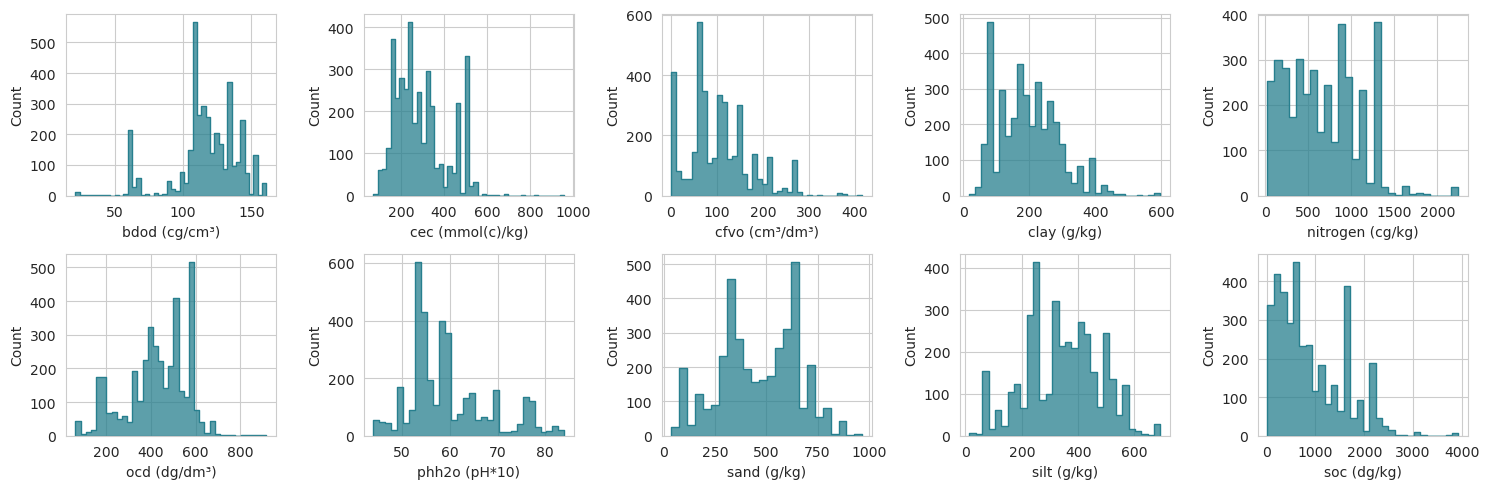

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5), sharey=False)
axes = axes.flatten()

for idx, col in enumerate(df_for_map.columns[9:19]):
    sns.histplot(data=df_for_map, x=col, ax=axes[idx], color="#277F8E", element="step")
plt.tight_layout()
fig.savefig("../figures/soil_attributes_hist.pdf", bbox_inches="tight")

In [15]:
from collections import Counter


def make_upset(col):
    ptus_env_counts = {}

    for i in ptus[ptus["Length"] > 1].index:
        ptus_env_counts[i] = Counter(ptus.loc[i][col].split(";"))

    ptu_env_df = pd.DataFrame.from_dict(ptus_env_counts, orient="index")
    ptu_has_env_df = ptu_env_df.notna()
    ptu_has_env_df = ptu_has_env_df.join(ptus["Origin"])
    upset = UpSet(
        from_indicators(lambda x: x.select_dtypes(bool), data=ptu_has_env_df),
        subset_size="count",
        show_counts=True,
        show_percentages=False,
        sort_by="cardinality",
        min_subset_size=50,
        intersection_plot_elements=0,
        element_size=40,
    )

    upset.add_stacked_bars(by="Origin")
    upset.plot()["totals"].set_xlabel("Number of PTUs")
    plt.savefig(f"../figures/upset_{col}.pdf", bbox_inches="tight")

/clusterfs/jgi/groups/science/homes/mbfiamenghi/.micromamba/envs/geo/lib/python3.12/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' 'black' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 'black' '#0000002e' '#0000002e' '#0000002e' 'black' 'black' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black' '#0000002e'
 '#0000002e' 'black' '#0000002e' '#0000002e' '#0000002e' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black

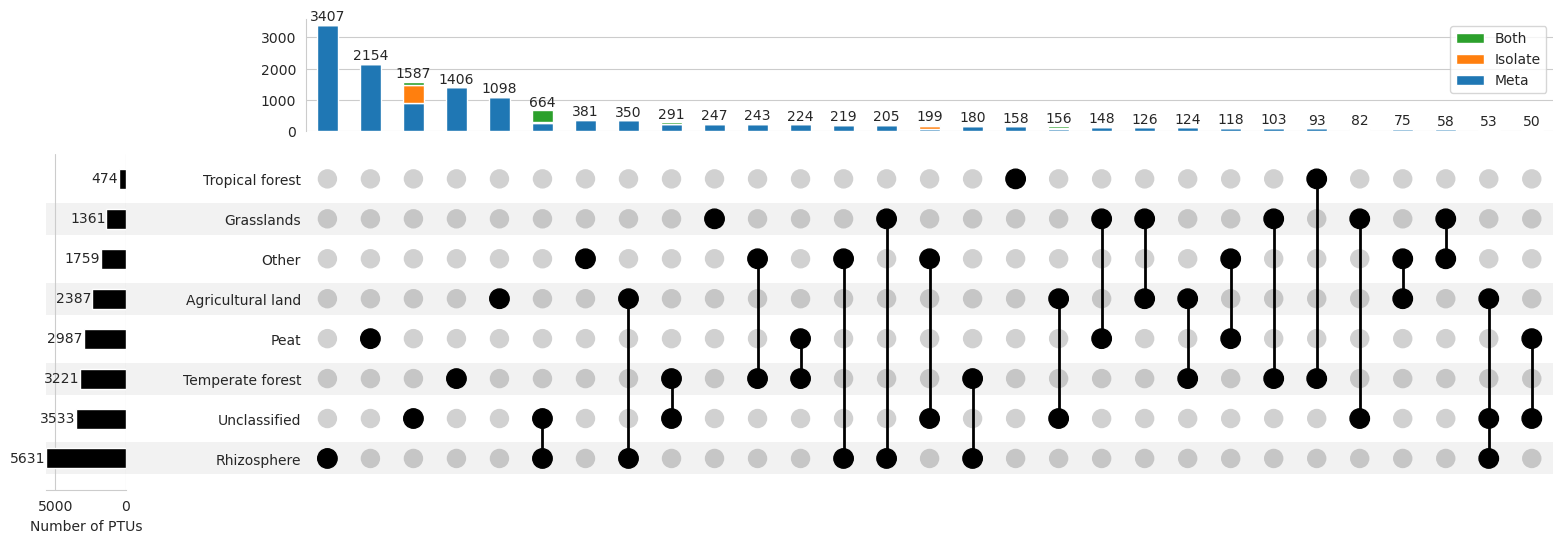

In [16]:
make_upset("Ecosystem Subtype Custom")

In [17]:
# make_upset("WWF_MHTNAM")

In [ ]:
ptus[ptus["Length"] >= 2]["Length"].sum()

56223

In [ ]:
for i in [2, 5, 20, 50, 100]:
    print(
        f">={i}",
        ptus[ptus["Length"] >= i]["Length"].sum(),
        round(ptus[ptus["Length"] >= i]["Length"].sum() / ptus["Length"].sum(), 2),
        ptus[ptus["Length"] >= i].shape[0],
        round(ptus[ptus["Length"] >= i].shape[0] / ptus.shape[0], 3),
    )
print(
    "1",
    ptus[ptus["Length"] == 1]["Length"].sum(),
    round(ptus[ptus["Length"] == 1]["Length"].sum() / ptus["Length"].sum(), 2),
    ptus[ptus["Length"] == 1].shape[0],
    round(ptus[ptus["Length"] == 1].shape[0] / ptus.shape[0], 2),
)

>=2 56223 0.57 15207 0.266
>=5 25705 0.26 2686 0.047
>=20 6508 0.07 186 0.003
>=50 2087 0.02 28 0.0
>=100 450 0.0 3 0.0
1 42058 0.43 42058 0.73


---
### Megaplasmids with conj, BGC and amr. Where are they found?

In [20]:
# with open("../ptu/megaplasmids_amr_bgc_conjscan.txt") as f:  # already derepped
#     megaplasmids = [i.strip() for i in f]
#     megaplasmids_oids = [
#         i.split("|")[0] if "IMGPR" not in i else i.split("_")[2] for i in megaplasmids
#     ]

# df_for_map[df_for_map["taxon_oid"].isin(megaplasmids_oids)][
#     "Ecosystem Subtype Custom"
# ].value_counts()

---
## Top Pfams/top Pfams per environment

In [21]:
with open("../ptu_derep/complete_plasmids_derep.txt") as f:
    complete_plasmids = [i.strip() for i in f]

In [22]:
with duckdb.connect("../soil_plasmid.db") as con:
    pfams_hits = (
        con.sql("SELECT * FROM hmm_outputs WHERE Query_name LIKE 'PF%'").pl().lazy()
    )

In [23]:
pfams_hits = (
    pfams_hits.with_columns(
        pl.col("Hit_name")
        .map_elements(
            lambda x: "Isolate"
            if any([i for i in ["IMGPR", "PLSDB", "Refsoil"] if i in x])
            else "Meta"
        )
        .alias("Origin"),
    )
    .with_columns(
        pl.col("Hit_name")
        .map_elements(
            lambda x: (
                "_".join(x.split("_")[0:-1]) if "IMGPR" not in x else x.split("|")[0]
            )
        )
        .alias("Plasmid_name")
    )
    .filter(pl.col("Plasmid_name").is_in(derep_plasmids))
    .with_columns(
        pl.col("Plasmid_name")
        .map_elements(
            lambda x: x.split("|")[0] if "IMGPR" not in x else x.split("_")[2]
        )
        .alias("taxon_oid")
    )
    .collect()
)

In [24]:
hit_descriptions = pd.read_csv(
    "../helper_data/PFAM_NCBIFAM_KOFAM_entries.tsv", sep="\t", index_col=0
)

pfam_descriptions = hit_descriptions[hit_descriptions["Source Database"] == "pfam"]

kofam_descriptions = hit_descriptions[hit_descriptions["Source Database"] == "kofam"]
pfam_descriptions.head()

,Name,Source Database,Type,Integrated Into,Integrated Signatures,GO Terms
Accession,,,,,,
PF00001,7 transmembrane receptor (rhodopsin family),pfam,family,IPR000276,NaN,NaN
PF00002,7 transmembrane receptor (Secretin family),pfam,family,IPR000832,NaN,NaN
PF00003,7 transmembrane sweet-taste receptor of 3 GCPR,pfam,domain,IPR017978,NaN,NaN
PF00004,ATPase family associated with various cellular...,pfam,domain,IPR003959,NaN,NaN
PF00005,ABC transporter,pfam,domain,IPR003439,NaN,NaN


In [25]:
ptus_mapping = {}

for idx, row in ptus.iterrows():
    for plasmid in row[2].split(","):
        plasmid = plasmid.split("|")[0] if "IMGPR" in plasmid else plasmid
        ptus_mapping[plasmid] = idx

In [26]:
pfams_hits = (
    pfams_hits.join(pl.from_pandas(df_for_map), on="taxon_oid")
    .with_columns(
        [
            pl.col("Plasmid_name")
            .map_elements(lambda x: ptus_mapping.get(x))
            .alias("PTU"),
            pl.col("Query_name")
            .map_elements(lambda x: pfam_descriptions.loc[x.split(".")[0], "Name"])
            .alias("Description"),
            pl.col("Plasmid_name").is_in(complete_plasmids).alias("complete"),
            pl.col("phh2o (pH*10)")
            .map_elements(
                lambda x: "Acid" if x <= 60 else "Basic" if x >= 80 else "Neutral"
            )
            .alias("ph_class"),
        ]
    )
    .drop(
        [
            "PTU Count",
            "PTU Count Bins",
            "Plasmid Count Bins",
            "Plasmid Count",
            "Origin_right",
        ]
    )
    .filter(pl.col("PTU").is_not_null())
)

pfams_hits.head()

Query_name,Hit_name,Hit_evalue,Hit_score,HMM_coverage,Origin,Plasmid_name,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Isolation Country,Ecosystem Subtype Custom,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),cfvo (cm³/dm³),clay (g/kg),nitrogen (cg/kg),ocd (dg/dm³),phh2o (pH*10),sand (g/kg),silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM,PTU,Description,complete,ph_class
str,str,f64,f64,f64,str,str,str,str,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,str,str,str,f64,str,str,str,bool,str
"""PF09299.15""","""3300025910|Ga0…",9.1000e-18,63.19,0.98,"""Meta""","""3300025910|Ga0…","""3300025910""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-10972""","""Mu transposase…",false,"""Acid"""
"""PF13379.10""","""3300025911|Ga0…",8.4900e-17,60.94,0.89,"""Meta""","""3300025911|Ga0…","""3300025911""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-14106""","""NMT1-like fami…",false,"""Acid"""
"""PF00345.24""","""3300025909|Ga0…",8.5900e-18,63.64,0.98,"""Meta""","""3300025909|Ga0…","""3300025909""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-04123""","""Pili and flage…",false,"""Acid"""
"""PF02195.22""","""3300025912|Ga0…",4.5400e-25,86.78,0.98,"""Meta""","""3300025912|Ga0…","""3300025912""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-06070""","""ParB/Sulfiredo…",false,"""Acid"""
"""PF00989.29""","""3300025911|Ga0…",3.4300e-29,100.3,0.96,"""Meta""","""3300025911|Ga0…","""3300025911""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-02832""","""PAS fold""",false,"""Acid"""


In [27]:
pfam_hits_for_upset = (
    pfams_hits.to_pandas()
    .assign(count=1)
    .pivot_table(
        index="Query_name",
        columns="Ecosystem Subtype Custom",
        values="count",
        fill_value=0,
    )
    .astype(bool)
    .reset_index()
)
pfam_hits_for_upset.head()

Ecosystem Subtype Custom,Query_name,Agricultural land,Grasslands,Other,Peat,Rhizosphere,Temperate forest,Tropical forest,Unclassified
0,PF00004.33,True,True,True,True,True,True,True,True
1,PF00005.31,True,True,True,True,True,True,True,True
2,PF00006.29,True,True,True,True,True,True,True,True
3,PF00009.31,True,True,True,True,True,True,True,True
4,PF00011.25,True,True,True,True,True,True,True,True


/clusterfs/jgi/groups/science/homes/mbfiamenghi/.micromamba/envs/geo/lib/python3.12/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' 'black' 'black' 'black' 'black' 'black' 'black' 'black'
 '#0000002e' 'black' 'black' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' 'black' '#0000002e' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black'
 'black' 'black' 'black' 'black' 'black' '#0000002e' '#0000002e' 'black'
 'black' 'black' 'black' 'black' '#0000002e' '#0000002e' '#0000002e'
 'black' 'black' 'black' 'black' 'black' '#0000002e' 'black' '#0000002e'
 'black' 'black' 'black' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' 'black' '#0000002e' '#0000002e

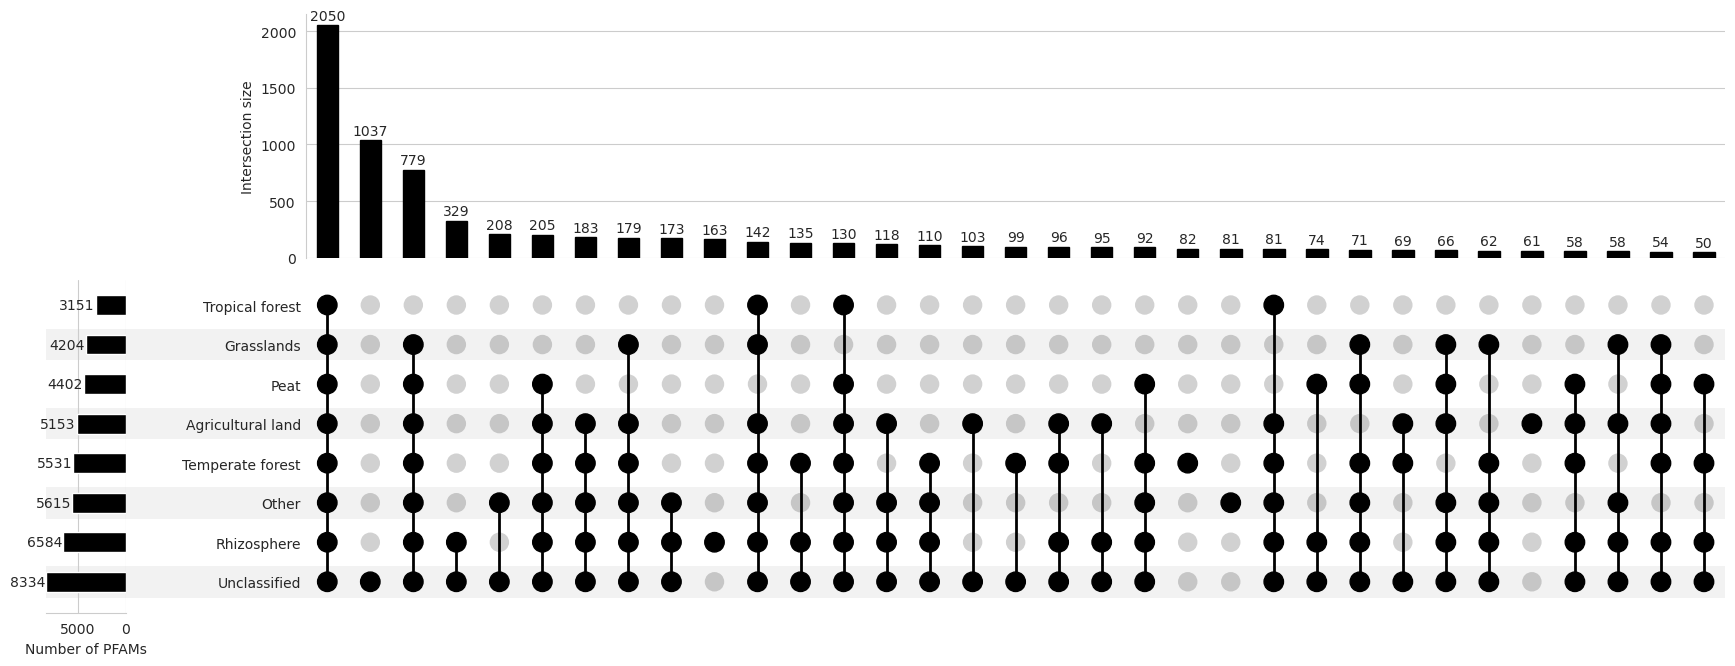

In [28]:
upset_pfams = UpSet(
    from_indicators(lambda x: x.select_dtypes(bool), data=pfam_hits_for_upset),
    subset_size="count",
    show_counts=True,
    show_percentages=False,
    sort_by="cardinality",
    min_subset_size=50,
    element_size=40,
)
upset_pfams.plot()["totals"].set_xlabel("Number of PFAMs")
plt.savefig("../figures/upset_pfams.pdf", bbox_inches="tight")

### PCAs

PCA for rep plasmids. Let's see if they cluster by environment using the relative PFam abundances.

In [29]:
pfams_hits_reps = pfams_hits.filter(pl.col("Plasmid_name").is_in(ptus[1].to_list()))

In [ ]:
pfams_hits_reps.select(["Plasmid_name", "Ecosystem Subtype Custom"]).unique()

Plasmid_name,Ecosystem Subtype Custom
str,str
"""3300025910|Ga0…","""Rhizosphere"""
"""3300027968|Ga0…","""Unclassified"""
"""3300028379|Ga0…","""Rhizosphere"""
"""3300010371|Ga0…","""Unclassified"""
"""3300027711|Ga0…","""Agricultural l…"
"""3300009036|Ga0…","""Rhizosphere"""
"""3300050241|Ga0…","""Agricultural l…"
"""PLSDB_NZ_CP054…","""Unclassified"""
"""Refsoil_NC_020…","""Unclassified"""


primeiro filtra as linhas que tiverem soma >= 100
depois divide os valores da coluna pelo total de plasmideos naquele ambiente

In [31]:
df_for_map[["taxon_oid", "Ecosystem Subtype Custom"]]

,taxon_oid,Ecosystem Subtype Custom
0,3300049023,Grasslands
1,3300012840,Grasslands
2,3300039503,Unclassified
3,3300042005,Rhizosphere
4,3300049265,Agricultural land
...,...,...
7133,Refsoil_NZ_HG916855.1,Unclassified
7134,Refsoil_NZ_HG938354.1,Unclassified
7135,Refsoil_NZ_HG938357.1,Unclassified
7136,Refsoil_NC_010181.1,Unclassified


In [32]:
plasmid_df = pd.DataFrame(derep_plasmids).rename(columns={0: "Plasmid"})
plasmid_df["taxon_oid"] = plasmid_df["Plasmid"].apply(
    lambda x: x.split("|")[0] if "IMGPR" not in x else x.split("_")[2]
)
plasmid_df = plasmid_df.join(
    df_for_map[["taxon_oid", "Ecosystem Subtype Custom"]].set_index("taxon_oid"),
    on="taxon_oid",
)

plasmids_per_env_dict = (
    plasmid_df[plasmid_df["Ecosystem Subtype Custom"] != "Unclassified"]
    .groupby("Ecosystem Subtype Custom")["Plasmid"]
    .nunique()
    .to_dict()
)

In [33]:
pfams_hits.head()

Query_name,Hit_name,Hit_evalue,Hit_score,HMM_coverage,Origin,Plasmid_name,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Isolation Country,Ecosystem Subtype Custom,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),cfvo (cm³/dm³),clay (g/kg),nitrogen (cg/kg),ocd (dg/dm³),phh2o (pH*10),sand (g/kg),silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM,PTU,Description,complete,ph_class
str,str,f64,f64,f64,str,str,str,str,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,str,str,str,f64,str,str,str,bool,str
"""PF09299.15""","""3300025910|Ga0…",9.1000e-18,63.19,0.98,"""Meta""","""3300025910|Ga0…","""3300025910""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-10972""","""Mu transposase…",false,"""Acid"""
"""PF13379.10""","""3300025911|Ga0…",8.4900e-17,60.94,0.89,"""Meta""","""3300025911|Ga0…","""3300025911""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-14106""","""NMT1-like fami…",false,"""Acid"""
"""PF00345.24""","""3300025909|Ga0…",8.5900e-18,63.64,0.98,"""Meta""","""3300025909|Ga0…","""3300025909""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-04123""","""Pili and flage…",false,"""Acid"""
"""PF02195.22""","""3300025912|Ga0…",4.5400e-25,86.78,0.98,"""Meta""","""3300025912|Ga0…","""3300025912""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-06070""","""ParB/Sulfiredo…",false,"""Acid"""
"""PF00989.29""","""3300025911|Ga0…",3.4300e-29,100.3,0.96,"""Meta""","""3300025911|Ga0…","""3300025911""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-02832""","""PAS fold""",false,"""Acid"""


In [34]:
pfam_pivot_counts = (
    pfams_hits.filter(pl.col("Ecosystem Subtype Custom") != "Unclassified")
    .group_by(["Ecosystem Subtype Custom", "Query_name"])
    .count()
    .with_columns(pl.col("Query_name").map_elements(lambda x: x.split(".")[0]))
    .to_pandas()
    .pivot(index="Query_name", columns="Ecosystem Subtype Custom", values="count")
    .fillna(0)
)
pfam_pivot = pfam_pivot_counts[pfam_pivot_counts.sum(axis=1) >= 100]
# make sure at least two envs have at least 1 pfam count
pfam_pivot["at_least_2_gt"] = pfam_pivot.gt(0).sum(axis=1).gt(2)
pfam_pivot = pfam_pivot[pfam_pivot["at_least_2_gt"]].drop("at_least_2_gt", axis=1)

# Normalize by environment counts first
pfam_pivot = pfam_pivot.div(pd.Series(plasmids_per_env_dict), axis=1)

# Standardize the data using sklearn's StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pfam_pivot)

# Convert back to DataFrame
pfam_pivot_scaled = pd.DataFrame(
    scaled_data, index=pfam_pivot.index, columns=pfam_pivot.columns
)

pfam_pivot_scaled.head()

/tmp/ipykernel_4093637/4227426088.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfam_pivot["at_least_2_gt"] = pfam_pivot.gt(0).sum(axis=1).gt(2)


Ecosystem Subtype Custom,Agricultural land,Grasslands,Other,Peat,Rhizosphere,Temperate forest,Tropical forest
Query_name,,,,,,,
PF00004,0.802777,0.682454,1.040857,1.071742,0.733451,0.737618,1.083119
PF00005,6.622219,3.686113,9.316832,2.066212,7.956666,3.343403,4.440286
PF00006,-0.401049,-0.361864,-0.439350,-0.233123,-0.258186,-0.329645,-0.405110
PF00009,-0.321174,-0.212676,-0.325488,-0.266272,-0.272823,-0.288063,-0.128231
PF00011,-0.235594,-0.153000,-0.169677,-0.281340,-0.082546,-0.208365,-0.197450


In [35]:
## old code
# pfam_pivot_counts = (
#     pfams_hits.filter(pl.col("Ecosystem Subtype Custom") != "Unclassified")
#     .group_by(["Ecosystem Subtype Custom", "Query_name"])
#     .count()
#     .with_columns(pl.col("Query_name").map_elements(lambda x: x.split(".")[0]))
#     .to_pandas()
#     .pivot(index="Query_name", columns="Ecosystem Subtype Custom", values="count")
#     .fillna(0)
# )
# pfam_pivot = pfam_pivot_counts[pfam_pivot_counts.sum(axis=1) >= 100]
# # make sure at least two envs have at least 1 pfam count
# pfam_pivot["at_least_2_gt"] = pfam_pivot.gt(0).sum(axis=1).gt(2)
# pfam_pivot = pfam_pivot[pfam_pivot["at_least_2_gt"]].drop("at_least_2_gt", axis=1)
# pfam_pivot = pfam_pivot.div(pd.Series(plasmids_per_env_dict), axis=1)
# cols = pfam_pivot.columns
# rows = pfam_pivot.index
# # normalize
# pfam_array = np.array(pfam_pivot)

# pfam_array = pfam_array.transpose() - pfam_array.mean(1)

# # scaling
# pfam_array = (pfam_array.transpose() / np.sqrt((pfam_array**2).sum(1))).transpose()

# # turn into df again
# pfam_pivot = pd.DataFrame(pfam_array, columns=rows, index=cols).T

# pfam_pivot.head()

In [36]:
pfam_pivot_counts.loc[
    [
        "PF00005",
        "PF00528",
        "PF00106",
        "PF03743",
        "PF05101",
        "PF03466",
        "PF00126",
    ]
].join(hit_descriptions["Name"])

,Agricultural land,Grasslands,Other,Peat,Rhizosphere,Temperate forest,Tropical forest,Name
Query_name,,,,,,,,
PF00005,1241.0,412.0,1637.0,792.0,4625.0,1078.0,141.0,ABC transporter
PF00528,635.0,263.0,1354.0,313.0,3668.0,517.0,85.0,Binding-protein-dependent transport system inn...
PF00106,918.0,679.0,999.0,722.0,4479.0,1058.0,122.0,short chain dehydrogenase
PF03743,989.0,689.0,850.0,2612.0,3472.0,2539.0,302.0,Bacterial conjugation TrbI-like protein
PF05101,751.0,513.0,745.0,2240.0,2644.0,2169.0,276.0,"Type IV secretory pathway, VirB3-like protein"
PF03466,796.0,443.0,1003.0,958.0,5593.0,1231.0,154.0,LysR substrate binding domain
PF00126,787.0,435.0,1000.0,929.0,5643.0,1212.0,158.0,"Bacterial regulatory helix-turn-helix protein,..."


In [37]:
# pfam_pivot_scaled.to_csv("pfam_pivot_for_pca.csv")

In [39]:
# completes only
plasmids_per_env_dict_complete = (
    df_plasmids[
        (df_plasmids["Ecosystem Subtype Custom"] != "Unclassified")
        & (df_plasmids["Plasmid"].isin(complete_plasmids))
    ]
    .groupby("Ecosystem Subtype Custom")["Plasmid"]
    .nunique()
    .to_dict()
)
pfam_pivot_counts = (
    pfams_hits.filter(
        (pl.col("Ecosystem Subtype Custom") != "Unclassified")
        & (pl.col("complete") == True)
    )
    .group_by(["Ecosystem Subtype Custom", "Query_name"])
    .count()
    .with_columns(pl.col("Query_name").map_elements(lambda x: x.split(".")[0]))
    .to_pandas()
    .pivot(index="Query_name", columns="Ecosystem Subtype Custom", values="count")
    .fillna(0)
)
# pfam_pivot = pfam_pivot_counts[pfam_pivot_counts.sum(axis=1) >= 100]
# make sure at least two envs have at least 1 pfam count
pfam_pivot["at_least_2_gt"] = pfam_pivot.gt(0).sum(axis=1).gt(2)
pfam_pivot = pfam_pivot[pfam_pivot["at_least_2_gt"]].drop("at_least_2_gt", axis=1)
pfam_pivot = pfam_pivot.div(pd.Series(plasmids_per_env_dict_complete), axis=1)
cols = pfam_pivot.columns
rows = pfam_pivot.index
# normalize
pfam_array = np.array(pfam_pivot)

pfam_array = pfam_array.transpose() - pfam_array.mean(1)

# scaling
pfam_array = (pfam_array.transpose() / np.sqrt((pfam_array**2).sum(1))).transpose()

# turn into df again
pfam_pivot = pd.DataFrame(pfam_array, columns=rows, index=cols).T

pfam_pivot.head()

Ecosystem Subtype Custom,Agricultural land,Grasslands,Other,Peat,Rhizosphere,Temperate forest,Tropical forest
Query_name,,,,,,,
PF00004,0.001868,-0.049542,0.033361,0.027801,0.020038,-0.023938,0.004065
PF00005,0.242984,-0.271323,0.422110,0.001929,0.383133,-0.064852,-0.131318
PF00009,-0.008527,-0.001881,-0.002357,-0.012870,-0.004145,-0.021164,0.009401
PF00012,-0.001413,-0.007707,-0.002550,0.000435,-0.005088,-0.009723,0.006390
PF00023,-0.019166,0.017946,-0.008660,-0.001816,-0.009259,-0.007009,0.002287


In [40]:
pfam_pivot.to_csv("pfam_pivot_for_pca_completes.csv")

Biplot done on R

In [42]:
pfam_pivot_counts.loc[
    [
        "PF13610",
        "PF07282",
        "PF01609",
        "PF01385",
        "PF12323",
        "PF03466",
        "PF00126",
        "PF00106",
    ]
].join(hit_descriptions["Name"])

,Agricultural land,Grasslands,Other,Peat,Rhizosphere,Temperate forest,Tropical forest,Name
Query_name,,,,,,,,
PF13610,181.0,0.0,12.0,1.0,0.0,215.0,0.0,DDE domain
PF07282,113.0,0.0,9.0,1.0,1.0,118.0,2.0,Putative transposase DNA-binding domain
PF01609,114.0,3.0,14.0,3.0,17.0,126.0,4.0,Transposase DDE domain
PF01385,98.0,0.0,10.0,0.0,0.0,97.0,1.0,Probable transposase
PF12323,105.0,0.0,8.0,0.0,0.0,102.0,1.0,Helix-turn-helix domain
PF03466,17.0,15.0,14.0,1.0,139.0,27.0,0.0,LysR substrate binding domain
PF00126,19.0,16.0,14.0,0.0,138.0,32.0,0.0,"Bacterial regulatory helix-turn-helix protein,..."
PF00106,23.0,19.0,23.0,1.0,122.0,23.0,0.0,short chain dehydrogenase


In [45]:
pfams_hits

Query_name,Hit_name,Hit_evalue,Hit_score,HMM_coverage,Origin,Plasmid_name,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Isolation Country,Ecosystem Subtype Custom,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),cfvo (cm³/dm³),clay (g/kg),nitrogen (cg/kg),ocd (dg/dm³),phh2o (pH*10),sand (g/kg),silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM,PTU,Description,complete,ph_class
str,str,f64,f64,f64,str,str,str,str,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,str,str,str,f64,str,str,str,bool,str
"""PF09299.15""","""3300025910|Ga0…",9.1000e-18,63.19,0.98,"""Meta""","""3300025910|Ga0…","""3300025910""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-10972""","""Mu transposase…",false,"""Acid"""
"""PF13379.10""","""3300025911|Ga0…",8.4900e-17,60.94,0.89,"""Meta""","""3300025911|Ga0…","""3300025911""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-14106""","""NMT1-like fami…",false,"""Acid"""
"""PF00345.24""","""3300025909|Ga0…",8.5900e-18,63.64,0.98,"""Meta""","""3300025909|Ga0…","""3300025909""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-04123""","""Pili and flage…",false,"""Acid"""
"""PF02195.22""","""3300025912|Ga0…",4.5400e-25,86.78,0.98,"""Meta""","""3300025912|Ga0…","""3300025912""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-06070""","""ParB/Sulfiredo…",false,"""Acid"""
"""PF00989.29""","""3300025911|Ga0…",3.4300e-29,100.3,0.96,"""Meta""","""3300025911|Ga0…","""3300025911""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-02832""","""PAS fold""",false,"""Acid"""
"""PF06114.17""","""3300025909|Ga0…",6.9300e-14,50.87,0.64,"""Meta""","""3300025909|Ga0…","""3300025909""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-07653""","""IrrE N-termina…",false,"""Acid"""
"""PF05930.16""","""3300025909|Ga0…",2.1700e-18,65.03,0.98,"""Meta""","""3300025909|Ga0…","""3300025909""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-08909""","""Prophage CP4-5…",false,"""Acid"""
"""PF00589.26""","""3300025909|Ga0…",2.2800e-20,72.24,0.76,"""Meta""","""3300025909|Ga0…","""3300025909""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…","""PTU-03932""","""Phage integras…",false,"""Acid"""
"""PF00589.26""","""3300025909|Ga0…",4.6700e-21,74.48,0.97,"""Meta""","""3300025909|Ga0…","""3300025909""","""Rhizosphere""",42.39,-85.37,"""USA""","""Rhizosphere""","""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA

In [46]:
# get PFAMs that are unique to each ecosystem
pfams_for_ecosystem = (
    pfams_hits.with_columns(
        Query_clean=pl.col("Query_name").map_elements(lambda x: x.split(".")[0])
    )
    .group_by("Query_clean")
    .agg(
        [
            pl.col("Ecosystem Subtype Custom").unique().alias("Unique_Ecosystems"),
        ]
    )
    .with_columns(
        pl.col("Unique_Ecosystems")
        .map_elements(lambda x: len(x))
        .alias("Num_ecosystems")
    )
    .with_columns(pl.col("Unique_Ecosystems").list.join(","))
)

pfams_for_ecosystem.head()

Query_clean,Unique_Ecosystems,Num_ecosystems
str,str,i64
"""PF11396""","""Peat,Rhizosphe…",4
"""PF08450""","""Peat,Temperate…",8
"""PF02733""","""Peat,Unclassif…",8
"""PF04279""","""Peat,Unclassif…",5
"""PF08442""","""Other,Temperat…",7


In [47]:
pfams_for_ecosystem = pfams_for_ecosystem.to_pandas().join(
    pfam_descriptions["Name"], on="Query_clean"
)

In [48]:
def unique_pfams_per_eco(ecosystem):
    return pfams_for_ecosystem[
        (pfams_for_ecosystem["Num_ecosystems"] == 1)
        & (pfams_for_ecosystem["Unique_Ecosystems"] == ecosystem)
    ][["Query_clean", "Unique_Ecosystems", "Name"]]


res = []
for i in [
    "Temperate forest",
    "Tropical forest",
    "Grasslands",
    "Peat",
    "Rhizosphere",
    "Agricultural land",
]:
    res.append(unique_pfams_per_eco(i))

pd.concat(res).to_csv("unique_pfams_per_eco.tsv", sep="\t", index=False)

---
## General PFam enrichment

Isso pq os plasmídeos de isolado tendem a ser maiores, então a chance de eles terem um Pfam X é maior. Oq a gente quer saber é se a chance de um gene aleatório de um plasmídeo meta ter o Pfam X é maior do que a chance de um gene aleatório de plasmídeo isolado

Eu faria uma outra modificação, eu calcularia isso por plasmídeo. Pra cada plasmídeo vc vai calcular: Número de genes com Pfam X / número de genes total

assim, vc fica com um número entre 0 a 1 pra cada plasmídeo, pra cada pfam

depois, pra cada pfam, vc pode fazer um teste T pra ver se tem diferença das médias

Fazer para cada PF 0 e 1 de plasmídeo

In [ ]:
import polars.selectors as cs

grouped_pfams = (
    pfams_hits.group_by(["Plasmid_name", "Query_clean"])
    .count()
    .pivot(index="Plasmid_name", columns="Query_clean", values="count")
    .fill_null(0)
    .join(pfams_hits.select(["Plasmid_name", "Origin"]), on="Plasmid_name")
    .cast({cs.numeric(): pl.Boolean})
    .drop("Plasmid_name")
    .group_by("Origin")
    .agg(pl.all())
)

In [ ]:
# import polars.selectors as cs

# grouped_pfams = (
#     pfams_hits.filter(pl.col('Plasmid_name').is_in(complete_plasmids)).group_by(["Plasmid_name", "Query_clean"])
#     .count()
#     .pivot(index="Plasmid_name", columns="Query_clean", values="count")
#     .fill_null(0)
#     .join(pfams_hits.select(["Plasmid_name", "Origin"]), on="Plasmid_name")
#     .cast({cs.numeric(): pl.Boolean})
#     .drop("Plasmid_name")
#     .group_by("Origin")
#     .agg(pl.all())
# )

In [ ]:
a = grouped_pfams.to_pandas().set_index("Origin").T
a.head()

Origin,Isolate,Meta
PF10139,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
PF00378,"[False, False, False, True, False, False, True...","[False, False, False, False, False, False, Fal..."
PF04335,"[True, False, False, False, False, True, False...","[False, False, True, False, False, False, Fals..."
PF10373,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
PF06277,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."


In [ ]:
def cohens_d(group1, group2):
    # Calculating means of the two groups
    mean1, mean2 = np.mean(group1), np.mean(group2)

    # Calculating pooled standard deviation
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

    # Calculating Cohen's d
    d = (mean1 - mean2) / pooled_std

    return d

In [ ]:
# Define the t-test calculation function
# 2min46s computation
def calculate_t_test(pfam):
    # print("Running", pfam)
    meta = a.loc[pfam, "Meta"]
    isolate = a.loc[pfam, "Isolate"]

    t, p = stats.ttest_ind(meta, isolate)
    cohens_d_val = cohens_d(meta, isolate)
    return (
        np.mean(meta),
        np.mean(isolate),
        meta.sum(),
        isolate.sum(),
        t,
        p,
        cohens_d_val,
    )


# Loop through unique pfam values and calculate t-test results
pfam_t_results = {pfam: calculate_t_test(pfam) for pfam in a.index}

In [ ]:
b = pd.DataFrame.from_dict(
    pfam_t_results,
    orient="index",
    columns=["Meta_mean", "Isolate_mean", "Meta_n", "Isolate_n", "t", "p", "Cohen_d"],
)
b = b[(b["Meta_n"] + b["Isolate_n"] >= 100)]

# adjust p values after filtering
b["q"] = stats.false_discovery_control(b["p"])

In [ ]:
b

,Meta_mean,Isolate_mean,Meta_n,Isolate_n,t,p,Cohen_d,q
PF10139,0.000936,0.001299,1127,1386,-8.191921,2.572211e-16,-0.010892,2.750042e-16
PF00378,0.103157,0.361959,124150,386331,-490.339155,0.000000e+00,-0.651952,0.000000e+00
PF04335,0.170955,0.210382,205745,224548,-75.761682,0.000000e+00,-0.100732,0.000000e+00
PF10373,0.000000,0.000793,0,846,-30.897989,1.405553e-209,-0.041082,2.184779e-209
PF06277,0.001032,0.001279,1242,1365,-5.483688,4.165928e-08,-0.007291,4.347346e-08
...,...,...,...,...,...,...,...,...
PF20315,0.000069,0.000076,83,81,-0.612856,5.399713e-01,-0.000815,5.422148e-01
PF09115,0.000146,0.000000,176,0,12.494385,8.033185e-36,0.016612,9.162987e-36
PF09866,0.000159,0.000000,191,0,13.016012,9.953736e-39,0.017306,1.146184e-38
PF12715,0.000000,0.000377,0,402,-21.294511,1.305665e-100,-0.028313,1.758697e-100


In [ ]:
b.loc[["PF12834", "PF13579"]]

,Meta_mean,Isolate_mean,Meta_n,Isolate_n,t,p,Cohen_d,q
PF12834,0.003641,0.017597,4382,18782,-104.713336,0.0,-0.139226,0.0
PF13579,0.027029,0.220918,32530,235793,-473.531945,0.0,-0.629605,0.0


In [ ]:
# export the unfiltered table for enrichment analysis in hypeR
# b.to_csv("pfam_t_test.tsv", sep="\t")

In [ ]:
# only complete plasmids pfams
import polars.selectors as cs

grouped_pfams = (
    pfams_hits.filter(pl.col("complete"))
    .group_by(["Plasmid_name", "Query_clean"])
    .count()
    .pivot(index="Plasmid_name", columns="Query_clean", values="count")
    .fill_null(0)
    .join(pfams_hits.select(["Plasmid_name", "Origin"]), on="Plasmid_name")
    .cast({cs.numeric(): pl.Boolean})
    .drop("Plasmid_name")
    .group_by("Origin")
    .agg(pl.all())
)
a = grouped_pfams.to_pandas().set_index("Origin").T
pfam_t_results = {pfam: calculate_t_test(pfam) for pfam in a.index}
b = pd.DataFrame.from_dict(
    pfam_t_results,
    orient="index",
    columns=["Meta_mean", "Isolate_mean", "Meta_n", "Isolate_n", "t", "p", "Cohen_d"],
)
b = b[(b["Meta_n"] + b["Isolate_n"] >= 100)]

# adjust p values after filtering
b["q"] = stats.false_discovery_control(b["p"])
# b.to_csv("pfam_t_test_completes.tsv", sep="\t")

## Planctomycetota functions

---

### Kofam analysis

In [35]:
with duckdb.connect("../soil_plasmid.db") as con:
    kofam_hits = (
        con.sql("SELECT * FROM hmm_outputs WHERE Query_name LIKE 'K%'").pl().lazy()
    )

In [36]:
# 2min 25s computation
kofam_hits = (
    kofam_hits.with_columns(
        [
            pl.col("Hit_name")
            .map_elements(
                lambda x: (
                    "Isolate"
                    if any(i for i in ["IMGPR", "PLSDB", "Refsoil"] if i in x)
                    else "Meta"
                )
            )
            .alias("Origin"),
            pl.col("Hit_name")
            .map_elements(
                lambda x: (
                    "_".join(x.split("_")[0:-1])
                    if "IMGPR" not in x
                    else x.split("|")[0]
                )
            )
            .alias("Plasmid_name"),
        ]
    )
    .filter(pl.col("Plasmid_name").is_in(derep_plasmids))
    .with_columns(
        [
            pl.col("Plasmid_name")
            .map_elements(
                lambda x: x.split("|")[0] if "IMGPR" not in x else x.split("_")[2]
            )
            .alias("taxon_oid"),
            pl.col("Plasmid_name").is_in(complete_plasmids).alias("complete"),
        ]
    )
    .with_columns(
        pl.col("Plasmid_name")
        .map_elements(lambda x: ptus_mapping.get(x, np.nan))
        .alias("PTU"),
    )
    .filter(pl.col("PTU").is_not_null())
    .join(pl.from_pandas(df_for_map).lazy(), on="taxon_oid")
    .collect()
)

kofam_hits.head()

Query_name,Hit_name,Hit_evalue,Hit_score,HMM_coverage,Origin,Plasmid_name,taxon_oid,complete,PTU,Ecosystem Subtype,Latitude,Longitude,Origin_right,Isolation Country,Ecosystem Subtype Custom,Plasmid Count,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),cfvo (cm³/dm³),clay (g/kg),nitrogen (cg/kg),ocd (dg/dm³),phh2o (pH*10),sand (g/kg),silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM
str,str,f64,f64,f64,str,str,str,bool,str,str,f64,f64,str,str,str,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,str,str,str,f64,str
"""K05847""","""3300025728|Ga0…",4.0800e-90,302.13,0.73,"""Meta""","""3300025728|Ga0…","""3300025728""",false,"""PTU-12992""","""Rhizosphere""",42.39,-85.37,"""Meta""","""USA""","""Rhizosphere""",146,"""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…"
"""K05847""","""3300025728|Ga0…",8.0900e-41,139.81,0.67,"""Meta""","""3300025728|Ga0…","""3300025728""",false,"""PTU-03288""","""Rhizosphere""",42.39,-85.37,"""Meta""","""USA""","""Rhizosphere""",146,"""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…"
"""K05874""","""3300025735|Ga0…",1.7900e-144,482.27,0.83,"""Meta""","""3300025735|Ga0…","""3300025735""",true,"""PTU-00073""","""Rhizosphere""",42.39,-85.37,"""Meta""","""USA""","""Rhizosphere""",168,"""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…"
"""K05877""","""3300025728|Ga0…",1.9500e-118,395.79,0.95,"""Meta""","""3300025728|Ga0…","""3300025728""",false,"""PTU-12058""","""Rhizosphere""",42.39,-85.37,"""Meta""","""USA""","""Rhizosphere""",146,"""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…"
"""K05877""","""3300025735|Ga0…",1.4400e-55,188.32,0.76,"""Meta""","""3300025735|Ga0…","""3300025735""",false,"""PTU-29571""","""Rhizosphere""",42.39,-85.37,"""Meta""","""USA""","""Rhizosphere""",168,"""Luvisols""",135.0,157.0,73.0,167.0,897.0,394.0,58.0,600.0,233.0,606.0,"""POINT (-85.37 …",182.0,"""North Central …",null,"""NA4""","""Nearctic""",4.0,"""Temperate Broa…"


KO enrichment

In [ ]:
grouped_kofams = (
    kofam_hits.group_by(["Plasmid_name", "Query_name"])
    .count()
    .pivot(index="Plasmid_name", columns="Query_name", values="count")
    .fill_null(0)
    .join(kofam_hits.select(["Plasmid_name", "Origin"]), on="Plasmid_name")
    .cast({cs.numeric(): pl.Boolean})
    .drop("Plasmid_name")
    .group_by("Origin")
    .agg(pl.all())
)

In [ ]:
a = grouped_kofams.to_pandas().set_index("Origin").T
a.head()

Origin,Meta,Isolate
K03203,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
K16098,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
K16438,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
K25106,"[True, True, False, False, True, True, True, T...","[True, True, True, True, True, True, True, Tru..."
K10235,"[True, True, False, False, True, True, True, T...","[True, True, True, True, True, True, True, Tru..."


In [ ]:
# Define the t-test calculation function
# 20min computation
def calculate_t_test(kofam):
    # print("Running", pfam)
    meta = a.loc[kofam, "Meta"]
    isolate = a.loc[kofam, "Isolate"]

    t, p = stats.ttest_ind(meta, isolate)
    cohens_d_val = cohens_d(meta, isolate)
    return (
        np.mean(meta),
        np.mean(isolate),
        np.array(meta).sum(),
        np.array(isolate).sum(),
        t,
        p,
        cohens_d_val,
    )


# Loop through unique kofam values and calculate t-test results
kofam_t_results = {kofam: calculate_t_test(kofam) for kofam in a.index}

In [ ]:
b = pd.DataFrame.from_dict(
    kofam_t_results,
    orient="index",
    columns=["Meta_mean", "Isolate_mean", "Meta_n", "Isolate_n", "t", "p", "Cohen_d"],
)
b = b[(b["Meta_n"] + b["Isolate_n"] >= 100)]

# adjust p values after filtering
b["q"] = stats.false_discovery_control(b["p"])

In [ ]:
# export the unfiltered table for enrichment analysis in hypeR
# b.to_csv("kofam_t_test.tsv", sep="\t")

In [37]:
kofam_hits_for_upset = (
    kofam_hits.to_pandas()
    .assign(count=1)
    .pivot_table(
        index="Query_name",
        columns="Ecosystem Subtype Custom",
        values="count",
        fill_value=0,
    )
    .astype(bool)
    .reset_index()
)
kofam_hits_for_upset.head()

Ecosystem Subtype Custom,Query_name,Agricultural land,Grasslands,Other,Peat,Rhizosphere,Temperate forest,Tropical forest,Unclassified
0,K00001,True,True,True,True,True,True,True,True
1,K00002,True,True,True,True,True,True,True,True
2,K00004,True,True,True,True,True,True,True,True
3,K00005,True,True,True,True,True,True,True,True
4,K00006,True,False,False,False,True,True,False,True


/clusterfs/jgi/groups/science/homes/mbfiamenghi/.micromamba/envs/geo/lib/python3.12/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black'
 'black' 'black' 'black' 'black' 'black' 'black' '#0000002e' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' 'black' 'black' 'black' 'black' 'black' 'black' '#0000002e'
 '#0000002e' 'black' 'black' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' 'black' 'black' 'black' 'black'
 'black' '#0000002e' 'black' '#0000002e' 'black' 'black' 'black' 'black'
 'black' 'black' '#0000002e' 'black' 'black' 'black' 'black' 'black'
 'black' '#0000002e' 'black' 'black' 'black' 'black' 'black' 'black'
 'black' '#0000002e' '#0000002e' '#0000002e' 'black' '#0000002e'
 '#0000002e' 'black' '#0000002e' '#0000002e' '#0000002e' '#

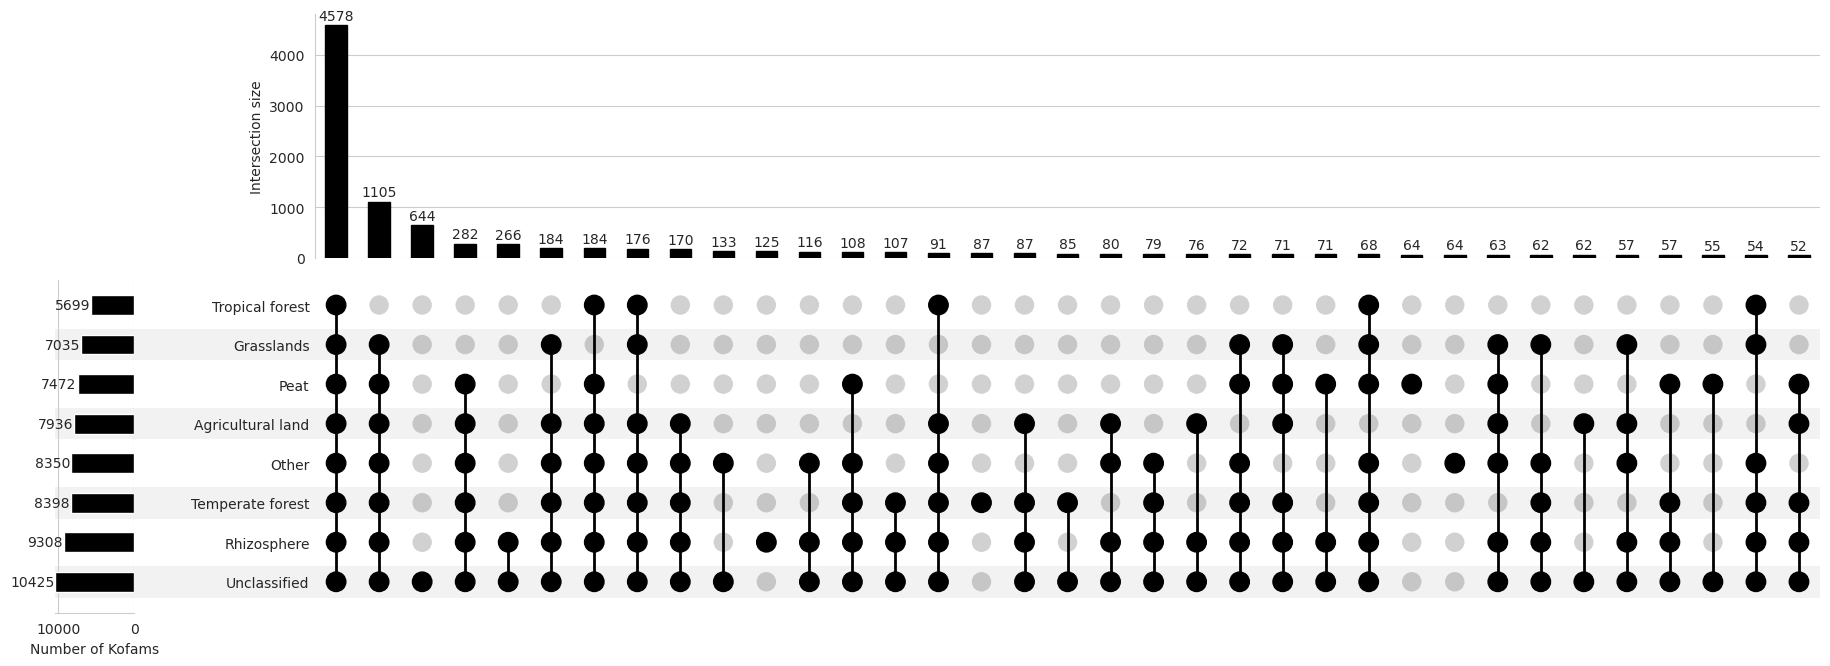

In [38]:
upset_kofams = UpSet(
    from_indicators(lambda x: x.select_dtypes(bool), data=kofam_hits_for_upset),
    subset_size="count",
    show_counts=True,
    show_percentages=False,
    sort_by="cardinality",
    min_subset_size=50,
    element_size=40,
)
upset_kofams.plot()["totals"].set_xlabel("Number of Kofams")
plt.savefig("../figures/upset_kofams.pdf", bbox_inches="tight")

In [51]:
kofam_pivot_counts = (
    kofam_hits.filter(pl.col("Ecosystem Subtype Custom") != "Unclassified")
    .group_by(["Ecosystem Subtype Custom", "Query_name"])
    .count()
    .with_columns(pl.col("Query_name").map_elements(lambda x: x.split(".")[0]))
    .to_pandas()
    .pivot(index="Query_name", columns="Ecosystem Subtype Custom", values="count")
    .fillna(0)
)
kofam_pivot = kofam_pivot_counts[kofam_pivot_counts.sum(axis=1) >= 100]
# make sure at least two envs have at least 1 pfam count
kofam_pivot["at_least_2_gt"] = kofam_pivot.gt(0).sum(axis=1).gt(2)
kofam_pivot = kofam_pivot[kofam_pivot["at_least_2_gt"]].drop("at_least_2_gt", axis=1)
kofam_pivot = kofam_pivot.div(pd.Series(plasmids_per_env_dict), axis=1)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(kofam_pivot)

# Convert back to DataFrame
kofam_pivot_scaled = pd.DataFrame(
    scaled_data, index=kofam_pivot.index, columns=kofam_pivot.columns
)

kofam_pivot_scaled.head()

/tmp/ipykernel_1413694/2972300202.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kofam_pivot['at_least_2_gt'] = kofam_pivot.gt(0).sum(axis=1).gt(2)


Ecosystem Subtype Custom,Agricultural land,Grasslands,Other,Peat,Rhizosphere,Temperate forest,Tropical forest
Query_name,,,,,,,
K00001,-0.010793,-0.002833,0.009539,-0.019246,0.019476,-0.021438,0.001424
K00002,-0.008649,-0.003824,0.003570,-0.003014,0.005728,-0.001459,-0.006110
K00004,-0.009059,-0.008527,0.010557,-0.017480,0.019767,-0.018526,-0.003442
K00005,-0.002032,-0.001035,0.001777,-0.001264,0.001169,-0.001529,-0.000389
K00007,-0.003385,-0.000365,0.000545,-0.001738,0.000579,-0.000816,0.003692


In [52]:
# kofam_pivot.to_csv("kofam_pivot_for_pca.csv")

In [53]:
kofam_pivot_counts.loc[
    [
        "K17737",
        "K09681",
        "K03195",
        "K20530",
        "K03199",
        "K06857",
        "K15600",
        "K05779",
        "K10822",
        "K19340",
    ]
].join(hit_descriptions["Name"])

,Agricultural land,Grasslands,Other,Peat,Rhizosphere,Temperate forest,Tropical forest,Name
Query_name,,,,,,,,
K17737,755.0,421.0,922.0,886.0,5215.0,1166.0,148.0,"LysR family transcriptional regulator, carniti..."
K09681,701.0,402.0,866.0,870.0,4900.0,1116.0,147.0,"LysR family transcriptional regulator, transcr..."
K03195,828.0,577.0,731.0,2261.0,2885.0,2231.0,262.0,type IV secretion system protein VirB10
K20530,879.0,611.0,807.0,2530.0,2966.0,2386.0,279.0,type IV secretion system protein TrbE [EC:7.4....
K03199,916.0,617.0,807.0,2559.0,3126.0,2457.0,277.0,type IV secretion system protein VirB4 [EC:7.4...
K06857,1178.0,395.0,1585.0,768.0,4503.0,1049.0,137.0,tungstate transport system ATP-binding protein...
K15600,1174.0,390.0,1586.0,760.0,4481.0,1038.0,137.0,putative hydroxymethylpyrimidine transport sys...
K05779,1167.0,385.0,1581.0,757.0,4416.0,1036.0,133.0,putative thiamine transport system ATP-binding...
K10822,1173.0,386.0,1582.0,773.0,4467.0,1044.0,133.0,nonpolar-amino-acid-transporting ATPase [EC:7....


In [54]:
kofam_pivot_counts = (
    kofam_hits.filter(
        (pl.col("Ecosystem Subtype Custom") != "Unclassified")
        & (pl.col("complete") == True)
    )
    .group_by(["Ecosystem Subtype Custom", "Query_name"])
    .count()
    .with_columns(pl.col("Query_name").map_elements(lambda x: x.split(".")[0]))
    .to_pandas()
    .pivot(index="Query_name", columns="Ecosystem Subtype Custom", values="count")
    .fillna(0)
)
kofam_pivot = kofam_pivot_counts[kofam_pivot_counts.sum(axis=1) >= 100]
# make sure at least two envs have at least 1 pfam count
kofam_pivot["at_least_2_gt"] = kofam_pivot.gt(0).sum(axis=1).gt(2)
kofam_pivot = kofam_pivot[kofam_pivot["at_least_2_gt"]].drop("at_least_2_gt", axis=1)
kofam_pivot = kofam_pivot.div(pd.Series(plasmids_per_env_dict_complete), axis=1)
cols = kofam_pivot.columns
rows = kofam_pivot.index
# normalize
kofam_array = np.array(kofam_pivot)

kofam_array = kofam_array.transpose() - kofam_array.mean(1)

# scaling
kofam_array = (kofam_array.transpose() / np.sqrt((kofam_array**2).sum(1))).transpose()

# turn into df again
kofam_pivot = pd.DataFrame(kofam_array, columns=rows, index=cols).T

kofam_pivot.head()

/tmp/ipykernel_1413694/1535057674.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kofam_pivot['at_least_2_gt'] = kofam_pivot.gt(0).sum(axis=1).gt(2)


Ecosystem Subtype Custom,Agricultural land,Grasslands,Other,Peat,Rhizosphere,Temperate forest,Tropical forest
Query_name,,,,,,,
K00023,-0.008729,0.056558,0.032728,-0.034646,0.060985,-0.021380,-0.036777
K00034,-0.008374,0.059633,0.031076,-0.033147,0.054792,-0.019382,-0.035253
K00038,-0.005129,0.064992,0.007375,-0.026550,0.041049,-0.017297,-0.028546
K00039,-0.009517,0.057373,0.033965,-0.034248,0.059677,-0.020851,-0.036373
K00046,-0.009397,0.057611,0.034326,-0.034132,0.058935,-0.020696,-0.036255


In [55]:
# kofam_pivot.to_csv("kofam_pivot_for_pca_completes.csv")

In [56]:
kofam_pivot_counts.loc[
    [
        "K07666",
        "K07660",
        "K11148",
        "K11049",
        "K05780",
        "K09697",
        "K15600",
        "K05779",
        "K20490",
        "K25158",
    ]
].join(hit_descriptions["Name"])

,Agricultural land,Grasslands,Other,Peat,Rhizosphere,Temperate forest,Tropical forest,Name
Query_name,,,,,,,,
K07666,97.0,5.0,11.0,2.0,28.0,77.0,6.0,"two-component system, OmpR family, response re..."
K07660,95.0,5.0,11.0,2.0,32.0,76.0,6.0,"two-component system, OmpR family, response re..."
K11148,9.0,16.0,16.0,0.0,93.0,5.0,0.0,dehydrogenase/reductase SDR family member 4-li...
K11049,24.0,17.0,23.0,1.0,117.0,16.0,0.0,CylG protein
K05780,81.0,27.0,28.0,1.0,161.0,51.0,0.0,alpha-D-ribose 1-methylphosphonate 5-triphosph...
K09697,153.0,29.0,36.0,1.0,218.0,118.0,0.0,sodium transport system ATP-binding protein [E...
K15600,153.0,29.0,36.0,1.0,218.0,118.0,0.0,putative hydroxymethylpyrimidine transport sys...
K05779,152.0,30.0,34.0,1.0,212.0,118.0,0.0,putative thiamine transport system ATP-binding...
K20490,151.0,27.0,33.0,1.0,211.0,118.0,0.0,lantibiotic transport system ATP-binding protein


K14628, only present in metaGs, is an enoyl reductase, involved in biosynthesys of polyketides. 47% (72 genes) in Rhizosphere + Agricultural land. How many PTUs?

In [57]:
kofam_hits.filter(pl.col("Query_name") == "K14628").select(
    ["PTU", "Ecosystem Subtype Custom"]
).unique()["Ecosystem Subtype Custom"].value_counts()

Ecosystem Subtype Custom,count
str,u32
"""Tropical fores…",3
"""Agricultural l…",11
"""Grasslands""",5
"""Temperate fore…",17
"""Other""",5
"""Unclassified""",16
"""Rhizosphere""",22
"""Peat""",1


In [58]:
# get KOss that are unique to each ecosystem
kofams_for_ecosystem = (
    kofam_hits.group_by("Query_name")
    .agg(
        [
            pl.col("Ecosystem Subtype Custom").unique().alias("Unique_Ecosystems"),
        ]
    )
    .with_columns(
        pl.col("Unique_Ecosystems")
        .map_elements(lambda x: len(x))
        .alias("Num_ecosystems")
    )
    .with_columns(pl.col("Unique_Ecosystems").list.join(","))
)

In [59]:
kofams_for_ecosystem = kofams_for_ecosystem.to_pandas().join(
    kofam_descriptions["Name"], on="Query_name"
)

In [61]:
def unique_kofams_per_eco(ecosystem):
    return kofams_for_ecosystem[
        (kofams_for_ecosystem["Num_ecosystems"] == 1)
        & (kofams_for_ecosystem["Unique_Ecosystems"] == ecosystem)
    ][["Query_name", "Unique_Ecosystems", "Name"]]


res = []
for i in [
    "Temperate forest",
    "Tropical forest",
    "Grasslands",
    "Peat",
    "Rhizosphere",
    "Agricultural land",
]:
    res.append(unique_kofams_per_eco(i))

pd.concat(res).to_csv("unique_kofams_per_eco.tsv", sep="\t", index=False)

In [ ]:
# get modules which are exclusive to one origin
meta_modules = [
    i.split(",")
    for i in kofam_hits.filter(pl.col("Origin") == "Meta")["modules"]
    if i is not None
]
meta_modules = [x for sublist in meta_modules for x in sublist]

isolate_modules = [
    i.split(",")
    for i in kofam_hits.filter(pl.col("Origin") == "Isolate")["modules"]
    if i is not None
]
isolate_modules = [x for sublist in isolate_modules for x in sublist]

unique_meta_modules = set(meta_modules) - set(isolate_modules)

unique_isolate_modules = set(isolate_modules) - set(meta_modules)

print(unique_meta_modules, unique_isolate_modules)

{'M00161', 'M00949', 'M00128', 'M00597', 'M00160', 'M00052', 'M00093', 'M00089', 'M00091', 'M00862', 'M00574'} {'M00363', 'M00859', 'M00074'}


In [ ]:
print(
    len(meta_kofams),
    len(unique_meta_kofams),
    len(isolate_kofams),
    len(unique_isolate_kofams),
)

6116 298 6269 451


In [ ]:
pathways_meta_unique = kofam_hits.filter(
    pl.col("Query_name").is_in(unique_meta_kofams)
)["pathways"]
pathways_meta_unique = pathways_meta_unique.map_elements(
    lambda x: x.split(",")[-1] if x is not None else None
).to_list()
pathways_meta_unique = [i.split(",") for i in pathways_meta_unique if i is not None]
pathways_meta_unique = [x for sublist in pathways_meta_unique for x in sublist]

Counter(pathways_meta_unique)

Counter({'map01100': 129,
         'map01110': 78,
         'map02020': 47,
         'map01232': 43,
         'map01120': 29,
         'map05111': 29,
         'map01230': 26,
         'map01240': 24,
         'map05152': 19,
         'map02024': 18,
         'map05170': 17,
         'map04626': 16,
         'map04016': 16,
         'map05230': 14,
         'map03240': 13,
         'map05418': 12,
         'map04916': 11,
         'map01200': 11,
         'map05132': 11,
         'map05417': 10,
         'map05022': 10,
         'map05164': 9,
         'map01250': 9,
         'map04114': 9,
         'map02040': 9,
         'map05143': 8,
         'map04640': 8,
         'map03030': 8,
         'map04010': 7,
         'map05034': 7,
         'map03259': 7,
         'map03440': 6,
         'map05223': 6,
         'map02030': 6,
         'map05235': 6,
         'map05169': 6,
         'map02010': 5,
         'map02026': 5,
         'map02025': 5,
         'map04710': 5,
         'map04934

In [ ]:
kofam_hits.filter(pl.col("Query_name").is_in(unique_meta_kofams))[
    "modules"
].value_counts().sort("count", descending=True)

modules,count
str,u32
null,664
"""M00852""",25
"""M00968""",13
"""M00034,M00609""",12
"""M00867""",11
"""M00051""",11
"""M00042""",11
"""M00023""",10
"""M00122""",8


In [ ]:
a = (
    kofam_hits_no_relax.unique(subset=["Query_name", "PTU", "Ecosystem Subtype Custom"])
    .group_by(["Ecosystem Subtype Custom", "Origin"])
    .agg("modules")
    .with_columns(pl.col("modules").list.join(","))
    .to_pandas()
)
a

,Ecosystem Subtype Custom,Origin,modules
0,Temperate forest,Meta,"null,null,null,M00545,null,null,null,null,null..."
1,None,Isolate,"null,null,null,null,null,null,null,M00061,null..."
2,Unclassified,Meta,"M00135,null,null,null,null,M00373,M00004,M0000..."
3,Grasslands,Meta,"null,null,null,null,null,null,null,null,null,n..."
4,Rhizosphere,Meta,"M00537,M00538,null,null,M00135,M00913,M00027,M..."
5,Agricultural land,Meta,"null,null,M00551,null,null,null,null,null,M003..."
6,Temperate forest,Isolate,"M00014,M00129,null,M00373,null,null,null,null,..."
7,Peat,Isolate,"M00014,null,null,M00083,M00572,M00104,M00970,M..."
8,Tropical forest,Isolate,"null,M00555,M00083,M00572,M00970,M00133,M00957..."
9,Other,Isolate,"null,null,null,null,null,null,null,null,null,n..."


In [ ]:
path_dict = defaultdict(dict)

for idx in a.index:
    num_paths = Counter(a.loc[idx, "modules"].split(","))
    del num_paths["null"]
    path_dict[f"{a.loc[idx, 'Ecosystem Subtype Custom']}-{a.loc[idx, 'Origin']}"] = (
        num_paths
    )

path_dict

defaultdict(dict,
            {'Temperate forest-Meta': Counter({'M00418': 1406,
                      'M00937': 1202,
                      'M00615': 1200,
                      'M00545': 1162,
                      'M00787': 1155,
                      'M00375': 1094,
                      'M00083': 1011,
                      'M00730': 849,
                      'M00534': 824,
                      'M00543': 823,
                      'M00373': 773,
                      'M00539': 760,
                      'M00419': 745,
                      'M00649': 731,
                      'M00745': 710,
                      'M00697': 699,
                      'M00014': 696,
                      'M00698': 671,
                      'M00778': 661,
                      'M00819': 626,
                      'M00642': 621,
                      'M00551': 601,
                      'M00781': 601,
                      'M00651': 600,
                      'M00374': 597,
                      'M0

In [ ]:
b = pd.DataFrame.from_dict(path_dict).fillna(0)

# Get the top 5 largest Module for each column
b.apply(lambda x: x.nlargest(5).index.tolist())

,Temperate forest-Meta,None-Isolate,Unclassified-Meta,Grasslands-Meta,Rhizosphere-Meta,Agricultural land-Meta,Temperate forest-Isolate,Peat-Isolate,Tropical forest-Isolate,Other-Isolate,Peat-Meta,Unclassified-Isolate,Grasslands-Isolate,Other-Meta,Rhizosphere-Isolate,Tropical forest-Meta,Agricultural land-Isolate
0,M00418,M00375,M00418,M00418,M00418,M00418,M00615,M00375,M00087,M00375,M00615,M00375,M00375,M00418,M00375,M00615,M00375
1,M00937,M00027,M00615,M00375,M00375,M00375,M00730,M00418,M00375,M00418,M00418,M00418,M00937,M00615,M00418,M00375,M00745
2,M00615,M00957,M00375,M00615,M00937,M00615,M00418,M00937,M00957,M00937,M00937,M00937,M00418,M00375,M00615,M00418,M00651
3,M00545,M00418,M00937,M00937,M00615,M00545,M00651,M00534,M00418,M00615,M00730,M00027,M00745,M00545,M00937,M00937,M00730
4,M00787,M00937,M00545,M00545,M00787,M00937,M00375,M00545,M00374,M00545,M00787,M00545,M00027,M00937,M00027,M00787,M00725


In [ ]:
b.idxmax()

Temperate forest-Meta        M00418
None-Isolate                 M00375
Unclassified-Meta            M00418
Grasslands-Meta              M00418
Rhizosphere-Meta             M00418
Agricultural land-Meta       M00418
Temperate forest-Isolate     M00615
Peat-Isolate                 M00375
Tropical forest-Isolate      M00087
Other-Isolate                M00375
Peat-Meta                    M00615
Unclassified-Isolate         M00375
Grasslands-Isolate           M00375
Other-Meta                   M00418
Rhizosphere-Isolate          M00375
Tropical forest-Meta         M00615
Agricultural land-Isolate    M00375
dtype: object

In [ ]:
df_bray = pd.read_csv("bray_dist.csv", index_col=0)

df_bray.head()

,Temperate.forest,Tropical.forest,Grasslands,Peat,Rhizosphere,Agricultural.land,Other,Unclassified
Temperate.forest,0.000000,0.969622,0.959291,0.960093,0.964244,0.951918,0.932069,0.949247
Tropical.forest,0.969622,0.000000,0.969190,0.996670,0.990923,0.979634,0.967451,0.989546
Grasslands,0.959291,0.969190,0.000000,0.975489,0.956029,0.943192,0.945913,0.965637
Peat,0.960093,0.996670,0.975489,0.000000,0.994334,0.990515,0.973887,0.986492
Rhizosphere,0.964244,0.990923,0.956029,0.994334,0.000000,0.915910,0.957255,0.937033


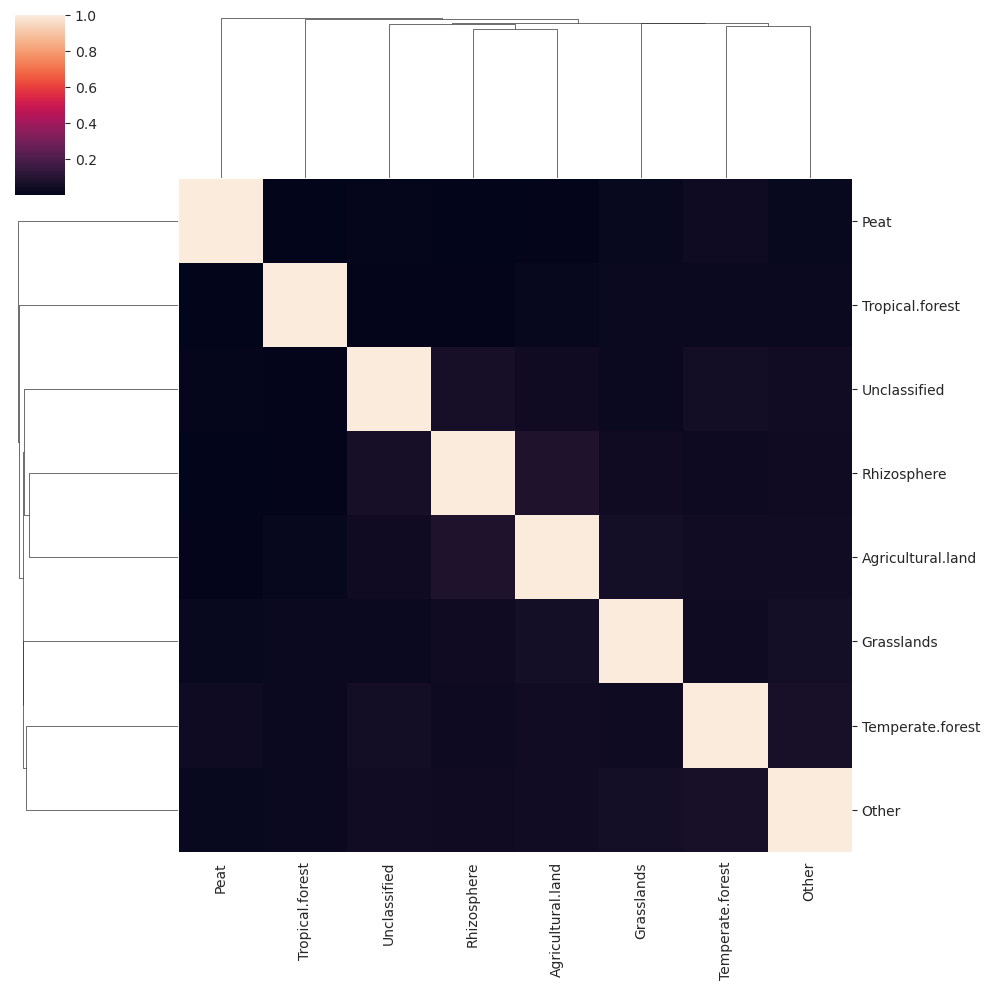

In [ ]:
sns.clustermap(1 - df_bray, cmap="rocket")

In [ ]:
kofams_per_ecosystem = (
    kofam_hits.group_by("Query_name")
    .agg(
        [
            pl.col("Ecosystem Subtype Custom").unique().alias("Unique_Ecosystems"),
        ]
    )
    .with_columns(
        pl.col("Unique_Ecosystems")
        .map_elements(lambda x: len(x))
        .alias("Num_ecosystems")
    )
    .with_columns(pl.col("Unique_Ecosystems").list.join(","))
    .filter((~pl.col("Unique_Ecosystems").str.contains("Unclassified|Other")))
)

kofams_per_ecosystem = (
    kofams_per_ecosystem.to_pandas()
    .join(kofam_descriptions["Name"], on="Query_name")
    .head()
)
kofams_per_ecosystem.head()

,Query_name,Unique_Ecosystems,Num_ecosystems,Name
0,K17751,Temperate forest,1,myosin heavy chain 6/7
1,K00887,"Agricultural land,Rhizosphere",2,undecaprenol kinase [EC:2.7.1.66]
2,K14713,Peat,1,"solute carrier family 39 (zinc transporter), m..."
3,K14487,Temperate forest,1,auxin responsive GH3 gene family
4,K06267,Peat,1,hyaluronan-mediated motility receptor


In [ ]:
a = (
    kofam_hits.filter(pl.col("PTU_novelty") == "Novel")
    .group_by("PTU")
    .agg(pl.col("Query_name"))
    .to_pandas()
)
a["Query_name"] = a["Query_name"].apply(set)
# a['Number of Kofams'] = a['Query_name'].apply(len)
a.head()

ColumnNotFoundError: unable to find column "PTU_novelty"; valid columns: ["Query_name", "Hit_name", "Hit_evalue", "Hit_score", "HMM_coverage", "pathways", "modules", "Name", "Origin", "Plasmid_name", "taxon_oid", "complete", "Ecosystem Subtype Custom", "Ecosystem Subtype", "PTU"]

Error originated just after this operation:
DF ["Query_name", "Hit_name", "Hit_evalue", "Hit_score"]; PROJECT */15 COLUMNS; SELECTION: "None"

In [ ]:
# with open('weird.txt', 'w') as f:
#     for i in pfams_hits.filter(pl.col('Query_name').str.contains('PF05119|PF01165|PF05119'))['Hit_name'].unique():
#         if 'IMGPR' in i:
#             f.write(f"{i.split('|')[0]}\n")
#         else:
#             f.write(f'{"_".join(i.split("_")[0:-1])}\n')

---

Plasmid Stats

In [ ]:
df_plasmid_lengths = pd.read_csv(
    "../ptu/all_soil_plasmids_with_isolates_rescued_length_new.tsv", sep="\t"
)
df_plasmid_lengths["Origin"] = df_plasmid_lengths["Plasmid"].apply(
    lambda x: "Meta" if not "IMGPR" in x else "Isolate"
)
df_plasmid_lengths["Length (kb)"] = df_plasmid_lengths["length"] / 1000
df_plasmid_lengths.head()

,Plasmid,length,Origin,Length (kb)
0,2088090014|GPIPI_16944593,5584,Meta,5.584
1,2088090014|GPIPI_16884012,8233,Meta,8.233
2,2088090014|GPIPI_17035422,5654,Meta,5.654
3,2088090014|GPIPI_17320127,5097,Meta,5.097
4,2088090014|GPIPI_16557027,6619,Meta,6.619


In [ ]:
df_plasmid_lengths["log10 Length"] = df_plasmid_lengths["length"].apply(np.log10)

In [ ]:
print(
    "Isolates mean plasmid length",
    df_plasmid_lengths[df_plasmid_lengths["Origin"] == "Isolate"]["length"].mean(),
)
print(
    "Isolates median plasmid length",
    df_plasmid_lengths[df_plasmid_lengths["Origin"] == "Isolate"]["length"].median(),
)
print(
    "Max isolate plasmid length",
    df_plasmid_lengths[df_plasmid_lengths["Origin"] == "Isolate"]["length"].max(),
)
print()
print(
    "Meta mean plasmid length",
    df_plasmid_lengths[df_plasmid_lengths["Origin"] == "Meta"]["length"].mean(),
)
print(
    "Meta median plasmid length",
    df_plasmid_lengths[df_plasmid_lengths["Origin"] == "Meta"]["length"].median(),
)
print(
    "Max meta plasmid length",
    df_plasmid_lengths[df_plasmid_lengths["Origin"] == "Meta"]["length"].max(),
)

Isolates mean plasmid length 99707.16078594161
Isolates median plasmid length 47956.0
Max isolate plasmid length 2096125

Meta mean plasmid length 19140.391637600023
Meta median plasmid length 8997.0
Max meta plasmid length 3525317


In [ ]:
df_for_map.head()

,Ecosystem Subtype,Latitude,Longitude,Origin,Ecosystem Subtype Custom,Plasmid Count,soil_class,PTU Count,PTU Count Bins,Plasmid Count Bins
taxon_oid,,,,,,,,,,
3300049023,Grasslands,38.53,-121.78,Meta,Grasslands,72,Luvisols,44.0,1-250,51-200
3300012840,Grasslands,43.07,-89.40,Meta,Grasslands,42,Luvisols,30.0,1-250,1-50
3300039503,Unclassified,63.88,-149.23,Meta,Unclassified,5,Cambisols,5.0,1-250,1-50
3300042005,Rhizosphere,41.20,-97.94,Meta,Rhizosphere,7,Kastanozems,6.0,1-250,1-50
3300049265,Agricultural land,38.55,-121.87,Meta,Agricultural land,1,Vertisols,1.0,1-250,1-50


In [ ]:
df_plasmid_lengths["taxon_oid"] = df_plasmid_lengths["Plasmid"].apply(
    lambda x: x.split("_")[2] if "IMGPR" in x else x.split("|")[0]
)

In [ ]:
df_plasmid_lengths = df_plasmid_lengths.join(
    df_for_map["Ecosystem Subtype Custom"], on="taxon_oid"
)

Plasmid Number of genes

In [ ]:
with open("all_soil_plasmids_with_isolates_rescued_prot_ids.txt") as f:
    prot_count = {}
    for i in f:
        plasmid = "_".join(i.split("_")[0:-1]) if "IMGPR" not in i else i.split("|")[0]
        if plasmid not in prot_count:
            prot_count[plasmid] = 1
        else:
            prot_count[plasmid] += 1

In [ ]:
df_plasmid_lengths["Plasmid_fix"] = df_plasmid_lengths["Plasmid"].apply(
    lambda x: x.split("|")[0] if "IMGPR" in x else x
)

In [ ]:
df_plasmid_lengths = df_plasmid_lengths.join(
    pd.DataFrame.from_dict(prot_count, orient="index", columns=["Num_genes"]),
    on="Plasmid_fix",
)

df_plasmid_lengths.head()

,Plasmid,length,Origin,Length (kb),taxon_oid,Ecosystem Subtype Custom,log10 Length,Plasmid_fix,Num_genes
0,2088090014|GPIPI_16944593,5584,Meta,5.584,2088090014,Grasslands,3.746945,2088090014|GPIPI_16944593,6.0
1,2088090014|GPIPI_16884012,8233,Meta,8.233,2088090014,Grasslands,3.915558,2088090014|GPIPI_16884012,12.0
2,2088090014|GPIPI_17035422,5654,Meta,5.654,2088090014,Grasslands,3.752356,2088090014|GPIPI_17035422,6.0
3,2088090014|GPIPI_17320127,5097,Meta,5.097,2088090014,Grasslands,3.707315,2088090014|GPIPI_17320127,6.0
4,2088090014|GPIPI_16557027,6619,Meta,6.619,2088090014,Grasslands,3.820792,2088090014|GPIPI_16557027,10.0


In [ ]:
df_plasmid_lengths["Num_genes_per_kb"] = (
    df_plasmid_lengths["Num_genes"] / df_plasmid_lengths["Length (kb)"]
)
df_plasmid_lengths.head()

,Plasmid,length,Origin,Length (kb),taxon_oid,Ecosystem Subtype Custom,log10 Length,Plasmid_fix,Num_genes,Num_genes_per_kb
0,2088090014|GPIPI_16944593,5584,Meta,5.584,2088090014,Grasslands,3.746945,2088090014|GPIPI_16944593,6.0,1.074499
1,2088090014|GPIPI_16884012,8233,Meta,8.233,2088090014,Grasslands,3.915558,2088090014|GPIPI_16884012,12.0,1.457549
2,2088090014|GPIPI_17035422,5654,Meta,5.654,2088090014,Grasslands,3.752356,2088090014|GPIPI_17035422,6.0,1.061196
3,2088090014|GPIPI_17320127,5097,Meta,5.097,2088090014,Grasslands,3.707315,2088090014|GPIPI_17320127,6.0,1.177163
4,2088090014|GPIPI_16557027,6619,Meta,6.619,2088090014,Grasslands,3.820792,2088090014|GPIPI_16557027,10.0,1.510802


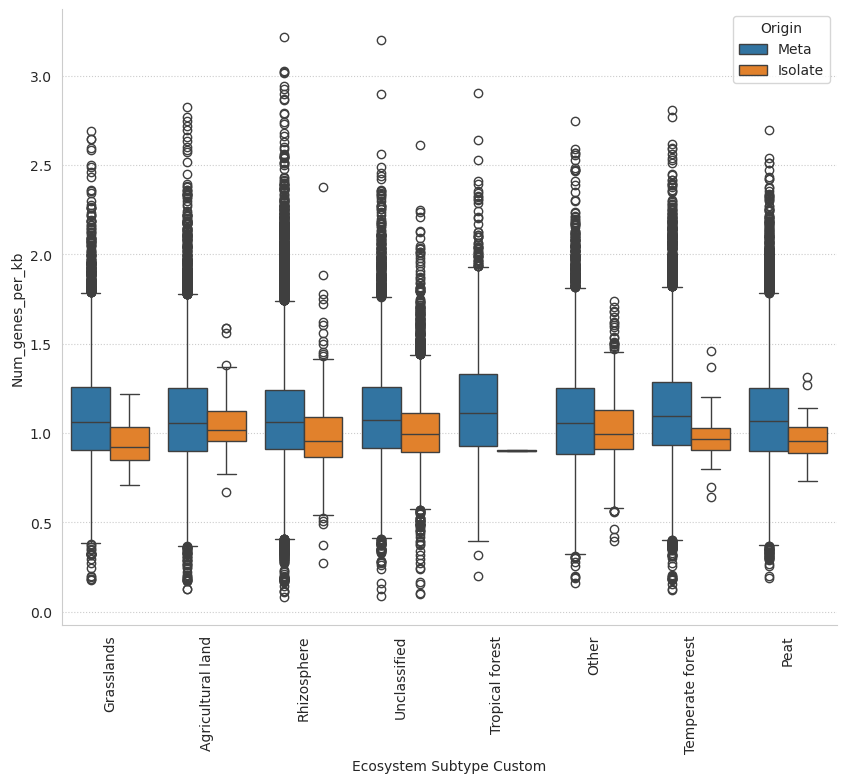

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(
    data=df_plasmid_lengths,
    x="Ecosystem Subtype Custom",
    y="Num_genes_per_kb",
    hue="Origin",
)

ax.xaxis.set_tick_params(rotation=90)
sns.despine()

## Rarefaction curves

In ecology, rarefaction is a technique to assess species richness from the results of sampling. Rarefaction allows the calculation of species richness for a given number of individual samples, based on the construction of so-called rarefaction curves. This curve is a plot of the number of species as a function of the number of samples. Rarefaction curves generally grow rapidly at first, as the most common species are found, but the curves plateau as only the rarest species remain to be sampled.[1]

The issue that occurs when sampling various species in a community is that the larger the number of individuals sampled, the more species that will be found. Rarefaction curves are created by randomly re-sampling the pool of N samples multiple times and then plotting the average number of species found in each sample (1,2, ... N). "Thus rarefaction generates the expected number of species in a small collection of n individuals (or n samples) drawn at random from the large pool of N samples."

So I should plot the number of plasmids per sample?

To create a rarefaction curve, you can: 
1. Randomly resample the pool of samples several times
2. Plot the average number of species found on each sample (plot the average number of plasmids per ptu?)

Did this in R with iNEXT

In [112]:
ptus.head()

,1,2,Length,oids,Ecosystem Subtype Custom,Ecosystem Subtype,WWF_MHTNAM,Origin,Full_origin,Num_unique_eco
0,,,,,,,,,,
PTU-00000,3300056587|Ga0562382_00532,"3300056587|Ga0562382_00532,3300041809|Ga045567...",187,"3300056587,3300041809,3300056587,3300055278,33...",Peat;Grasslands;Peat;Temperate forest;Peat;Pea...,Peat;Grasslands;Peat;Temperate forest;Peat;Pea...,Tundra;Temperate Conifer Forests;Tundra;Temper...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...,1
PTU-00001,3300056791|Ga0562384_00281,"3300056791|Ga0562384_00281,3300054973|Ga049542...",158,"3300056791,3300054973,3300047661,3300051166,33...",Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;P...,Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;P...,Tundra;Tundra;Tundra;Tundra;Tundra;Tundra;Tund...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...,1
PTU-00002,3300046709|Ga0495471_0000157,"3300046709|Ga0495471_0000157,3300046788|Ga0495...",105,"3300046709,3300046788,3300046461,3300046811,33...",Agricultural land;Agricultural land;Rhizospher...,Agricultural land;Agricultural land;Rhizospher...,Temperate Conifer Forests;Temperate Conifer Fo...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...,1
PTU-00003,3300046559|Ga0495667_0000358,"3300046559|Ga0495667_0000358,3300036401|Ga0373...",98,"3300046559,3300036401,3300046543,3300046724,33...",Rhizosphere;Rhizosphere;Rhizosphere;Agricultur...,Rhizosphere;Rhizosphere;Rhizosphere;Agricultur...,Temperate Conifer Forests;Temperate Conifer Fo...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...,1
PTU-00004,3300056834|Ga0562381_00901,"3300056834|Ga0562381_00901,3300056587|Ga056238...",85,"3300056834,3300056587,3300048796,3300048785,33...",Peat;Peat;Peat;Peat;Peat;Temperate forest;Gras...,Peat;Peat;Peat;Peat;Peat;Temperate forest;Gras...,Tundra;Tundra;Tundra;Tundra;Tundra;Temperate C...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...,1


In [113]:
# (pd.DataFrame(ptus['Ecosystem Subtype Custom'].str.split(';').explode()).reset_index().rename(columns={0: 'PTU'}).pivot_table(index='PTU', columns='Ecosystem Subtype Custom', aggfunc='size', fill_value=0)).to_csv('ptu_abundance_per_ecosystem.tsv', sep='\t')

In [ ]:
# pd.DataFrame.from_dict(ptus_presence_absence).to_csv('ptu_presence_absence_for_rarefaction.tsv', sep='\t')

In [ ]:
from collections import defaultdict

rare_ptus = defaultdict(list)

for i in ptus.index:
    for oid in ptus.loc[i, "oids"].split(","):
        rare_ptus[oid].append(i)

In [ ]:
test = {}
for ptu in ptus.index:
    test[ptu] = {}
    for ecosystem in [
        "Temperate forest",
        "Tropical forest",
        "Grasslands",
        "Peat",
        "Rhizosphere",
        "Agricultural land",
        "Other",
        "Unclassified",
    ]:
        test[ptu][ecosystem] = len(
            [
                i
                for i in ptus.loc[ptu, "Ecosystem Subtype Custom"].split(",")
                if i == ecosystem
            ]
        )

pd.DataFrame.from_dict(test).T.to_csv("ptu_abundance_per_ecosystem.tsv", sep="\t")

In [ ]:
# rare_ptus_meta_list = []
# rare_ptus_isolate_list = []

# rare_ptus_known_list = []
# rare_ptus_novel_list = []

# for ptu in (
#     meta_ptus := ptus[(ptus["Origin"] == "Meta") | (ptus["Origin"] == "Both")]
# ).index:
#     for plasmid in meta_ptus.loc[ptu, 2].split(","):
#         rare_ptus_meta_list.append(ptu)

# for ptu in (
#     isolate_ptus := ptus[(ptus["Origin"] == "Isolate") | (ptus["Origin"] == "Both")]
# ).index:
#     for plasmid in isolate_ptus.loc[ptu, 2].split(","):
#         rare_ptus_isolate_list.append(ptu)

# for ptu in (novel_ptus := ptus[(ptus["novelty"] == "Novel")]).index:
#     for plasmid in novel_ptus.loc[ptu, 2].split(","):
#         rare_ptus_novel_list.append(ptu)

# for ptu in (
#     known_ptus := ptus[(ptus["novelty"] == "Known") | (ptus["novelty"] == "Both")]
# ).index:
#     for plasmid in known_ptus.loc[ptu, 2].split(","):
#         rare_ptus_known_list.append(ptu)

In [ ]:
# rare_ptus_env_dict = defaultdict(list)
# for ptu in ptus.index:
#     for ecosystem in ptus.loc[ptu, "Ecosystem Subtype Custom"].split(","):
#         rare_ptus_env_dict[ecosystem].append(ptu)

# for k, v in rare_ptus_env_dict.items():
#     print(k, len(v), len(set(v)))

Peat 23595 7829
Grasslands 7573 5311
Temperate forest 19102 12739
Unclassified 17860 11553
Other 8955 6034
Agricultural land 13091 6844
Rhizosphere 43808 14259
Tropical forest 2228 1352
 31 31


In [ ]:
# def make_rarefaction_curve_single(ptu_list, n_iterations=10):
#     rarefaction_curves = []
#     sampled_ptus = set()
#     for _ in range(n_iterations):
#         rarefaction_curve = []
#         shuffled_ptus = np.random.choice(ptu_list, size=len(ptu_list), replace=False)
#         for ptu in shuffled_ptus:
#             sampled_ptus.add(ptu)
#             rarefaction_curve.append(len(sampled_ptus))
#         rarefaction_curves.append(rarefaction_curve)
#         sampled_ptus = set()
#     return np.array(rarefaction_curves).mean(axis=0)


# def make_rarefaction_curve_joined(ptu_lists, n_iterations=10):
#     rarefaction_curves = []
#     sampled_ptus = set()
#     for _ in range(n_iterations):
#         rarefaction_curve = []
#         for ptu_list in ptu_lists:
#             shuffled_ptus = np.random.choice(
#                 ptu_list, size=len(ptu_list), replace=False
#             )
#             for ptu in shuffled_ptus:
#                 sampled_ptus.add(ptu)
#                 rarefaction_curve.append(len(sampled_ptus))
#         rarefaction_curves.append(rarefaction_curve)
#         sampled_ptus = set()
#     return np.array(rarefaction_curves).mean(axis=0)

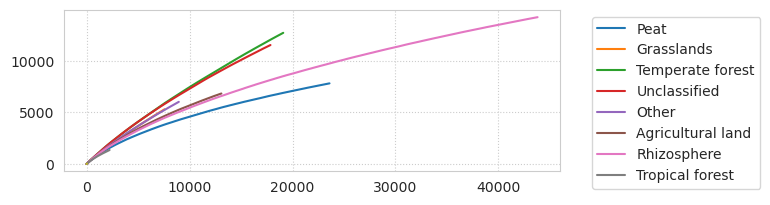

In [ ]:
# fig, ax = plt.subplots()
# for k, v in rare_ptus_env_dict.items():
#     sns.lineplot(make_rarefaction_curve_single(v), label=k)

# ax.set_aspect("equal")
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

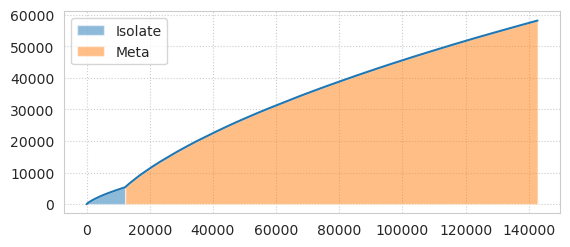

In [ ]:
# joined_curve = make_rarefaction_curve_joined(
#     [rare_ptus_isolate_list, rare_ptus_meta_list]
# )

# fig, ax = plt.subplots()


# sns.lineplot(joined_curve, ax=ax)

# ax.fill_between(
#     np.arange(len(rare_ptus_isolate_list)),
#     joined_curve[: len(rare_ptus_isolate_list)],
#     alpha=0.5,
#     label="Isolate",
# )
# ax.fill_between(
#     np.arange(len(rare_ptus_isolate_list), len(joined_curve)),
#     joined_curve[len(rare_ptus_isolate_list) :],
#     alpha=0.5,
#     label="Meta",
# )

# ax.set_aspect("equal")
# ax.legend()

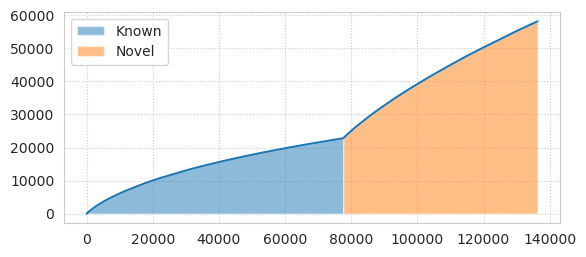

In [ ]:
# joined_curve = make_rarefaction_curve_joined(
#     [rare_ptus_known_list, rare_ptus_novel_list]
# )

# fig, ax = plt.subplots()


# sns.lineplot(joined_curve, ax=ax)

# ax.fill_between(
#     np.arange(len(rare_ptus_known_list)),
#     joined_curve[: len(rare_ptus_known_list)],
#     alpha=0.5,
#     label="Known",
# )
# ax.fill_between(
#     np.arange(len(rare_ptus_known_list), len(joined_curve)),
#     joined_curve[len(rare_ptus_known_list) :],
#     alpha=0.5,
#     label="Novel",
# )

# ax.set_aspect("equal")
# ax.legend()

In [ ]:
# import scipy.optimize as optimization


# def heap_law(n, p_kappa, p_gamma) -> float:
#     return p_kappa * n**p_gamma


# gamma_dict = {}

# print("Kappa and gamma for ecosystems")
# for k, v in rare_ptus_env_dict.items():
#     if len(set(v)) > 100:
#         res = optimization.curve_fit(
#             heap_law,
#             np.arange(100),
#             make_rarefaction_curve_single(np.random.choice(v, 100, replace=False)),
#             np.array([0.0, 0.0]),
#         )
#         kappa, gamma = res[0]
#         error_k, error_g = np.sqrt(np.diag(res[1]))
#         gamma_dict[k] = (gamma, error_g)
#         print(f"{k}: gamma={gamma:.4f}, kappa={kappa:.4f}")

# print("\nKappa and gamma for meta and isolates (respectively)")

# for lst in [rare_ptus_meta_list, rare_ptus_isolate_list]:
#     res = optimization.curve_fit(
#         heap_law,
#         np.arange(5_000),
#         make_rarefaction_curve_single(np.random.choice(lst, 5_000, replace=False)),
#         np.array([0.0, 0.0]),
#     )
#     kappa, gamma = res[0]
#     error_k, error_g = np.sqrt(np.diag(res[1]))
#     print(f"gamma={gamma:.4f}, kappa={kappa:.4f}")

# print("\nKappa and gamma for Novel and Known (respectively)")

# for lst in [rare_ptus_novel_list, rare_ptus_known_list]:
#     res = optimization.curve_fit(
#         heap_law,
#         np.arange(5_000),
#         make_rarefaction_curve_single(np.random.choice(lst, 5_000, replace=False)),
#         np.array([0.0, 0.0]),
#     )
#     kappa, gamma = res[0]
#     error_k, error_g = np.sqrt(np.diag(res[1]))
#     print(f"gamma={gamma:.4f}, kappa={kappa:.4f}")

Kappa and gamma for ecosystems
Peat: gamma=0.9717, kappa=1.1356
Grasslands: gamma=0.9593, kappa=1.1558
Temperate forest: gamma=0.9777, kappa=1.1162
Unclassified: gamma=0.9721, kappa=1.1365
Other: gamma=0.9651, kappa=1.1599
Agricultural land: gamma=0.9571, kappa=1.1899
Rhizosphere: gamma=0.9525, kappa=1.1918
Tropical forest: gamma=0.9510, kappa=1.1996

Kappa and gamma for meta and isolates (respectively)
gamma=0.9210, kappa=1.6771
gamma=0.8098, kappa=2.8282

Kappa and gamma for Novel and Known (respectively)
gamma=0.9397, kappa=1.4810
gamma=0.8566, kappa=2.4854


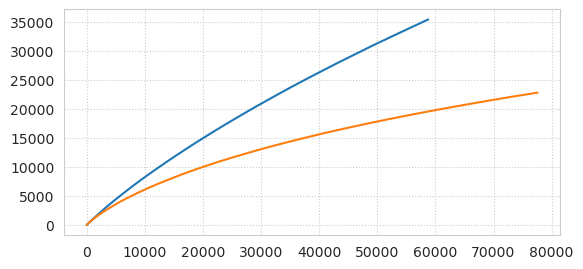

In [ ]:
# fig, ax = plt.subplots()
# for origin_list in [rare_ptus_novel_list, rare_ptus_known_list]:
#     sns.lineplot(make_rarefaction_curve_single(origin_list), ax=ax)
# ax.set_aspect("equal")